## 도로 위험 상황 예보 지도 시각화(히트맵)

In [1]:
import pandas as pd
import folium
from folium import plugins

# CSV 데이터 읽기
df = pd.read_csv("도로위험상황예보.csv")

# 필요한 열만 선택하여 DataFrame 생성
columns_of_interest = ["RSK_ELMN_NM", "RSK_ELMN_GRD", "RN_1HR", "AIRTP", "LOT", "LAT", "LOTNO_ADDR", "ROAD_NM_ADDR"]
df = df[columns_of_interest]

# LAT, LOT을 숫자형으로 변환
df['LAT'] = pd.to_numeric(df['LAT'], errors='coerce')
df['LOT'] = pd.to_numeric(df['LOT'], errors='coerce')

# 위험등급에 따른 강도 매핑 함수
def get_risk_intensity(risk_grade):
    # 알파벳 순으로 강도를 매핑
    if risk_grade == 'E':
        return 0.2  # 낮은 강도
    elif risk_grade == 'F':
        return 0.4  # 중간 강도
    elif risk_grade == 'G':
        return 0.6  # 높은 강도
    elif risk_grade == 'J':
        return 0.8  # 높은 강도
    elif risk_grade == 'L':
        return 1.0  # 높은 강도
   
    else:
        return 0.3  # 기타 경우 (기본값)

# 히트맵 데이터를 위한 리스트 생성
heat_data = []

# 각 위치에 마커 추가 및 히트맵 데이터 생성
for idx, row in df.iterrows():
    lat = float(row['LAT'])
    lot = float(row['LOT'])
    
    # 위험등급에 따른 강도 계산
    risk_grade = row['RSK_ELMN_GRD']
    intensity = get_risk_intensity(risk_grade)
    
    # 강도에 따른 히트맵 데이터 추가
    heat_data.append([lat, lot, intensity])

# 지도 중심 좌표 설정
map_center = [df['LAT'].mean(), df['LOT'].mean()]

# 지도 초기화
m = folium.Map(location=map_center, zoom_start=7)

# 히트맵 추가
plugins.HeatMap(heat_data).add_to(m)

# 지도 출력
m

## 도로 위험 상황 예보 지도 시각화(산점도)

In [2]:
import pandas as pd
import folium

# CSV 데이터 읽기
df = pd.read_csv("도로위험상황예보.csv")

# 필요한 열만 선택하여 DataFrame 생성
columns_of_interest = ["RSK_ELMN_NM", "RSK_ELMN_GRD", "RN_1HR", "AIRTP", "LOT", "LAT", "LOTNO_ADDR", "ROAD_NM_ADDR"]
df = df[columns_of_interest]

# LAT, LOT을 숫자형으로 변환
df['LAT'] = pd.to_numeric(df['LAT'], errors='coerce')
df['LOT'] = pd.to_numeric(df['LOT'], errors='coerce')

# 위험등급에 따른 색상 매핑 함수 (8개 등급을 RGB 값으로 나누기)
def get_risk_color(risk_grade):
    # 8개 등급에 맞춰 점진적으로 색상 변화
    # (각각의 등급은 0~7로 표시됩니다)
    risk_map = {
        'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
        'J': '#FF7F00',    # 두번째 위험도 -> 주황
        'G': '#00FF00',    # 낮은 위험도 -> 초록
        'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
        'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑

    }
    
    # 위험등급을 A~H로 매핑하여 색상 반환
    return risk_map.get(risk_grade, 'rgb(255, 255, 255)')  # 기본값은 흰색 (알 수 없는 등급)

# 지도 중심 좌표 설정
map_center = [df['LAT'].mean(), df['LOT'].mean()]

# 지도 초기화
m = folium.Map(location=map_center, zoom_start=7)

# 각 위치에 원형 마커 추가
for idx, row in df.iterrows():
    lat = float(row['LAT'])
    lot = float(row['LOT'])
    
    # 위험등급에 따른 색상 설정
    risk_grade = row['RSK_ELMN_GRD']
    rgb_color = get_risk_color(risk_grade)
    
    # 위험 요소와 관련된 정보 설정
    risk_name = row['RSK_ELMN_NM']
    precipitation = row['RN_1HR']
    temperature = row['AIRTP']
    lot_address = row['LOTNO_ADDR']
    road_address = row['ROAD_NM_ADDR']
    
    popup_text = f"""위험 요소: {risk_name}<br>
                     위험 등급: {risk_grade}<br>
                     강수량 (1시간): {precipitation}mm<br>
                     기온: {temperature}°C<br>
                     지번 주소: {lot_address}<br>
                     도로명 주소: {road_address}"""
    
    # 원형 마커 추가 (크기 줄이기 위해 radius 값 조정)
    folium.CircleMarker(
        location=[lat, lot],
        radius=2,  # 마커 크기 설정 (기본값보다 작게 설정)
        color=rgb_color,  # 마커 외곽선 색상 설정
        fill=True,
        fill_color=rgb_color,  # 마커 내부 색상 설정
        fill_opacity=1,  # 투명도 설정
        popup=popup_text  # 클릭 시 정보 표시
    ).add_to(m)

# 지도 저장
m

## 도로 위험 상황 예보 API 데이터 수집 및 필터링

In [3]:
import requests
import json
from urllib.parse import urlencode, quote
import urllib3

# SSL 경고 비활성화
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# API 정보 설정
base_url = "https://www.safetydata.go.kr"
data_name = "/V2/api/DSSP-IF-10005"  # 한글 경로 그대로 사용
service_key = "8522U83JUHE40QF2"  # 실제 서비스 키를 입력하세요

# 초기값 설정
total_data = []  # 전체 데이터를 누적할 리스트
max_pages = 33  # 최대 페이지 수 설정
num_of_rows = 100  # 한 페이지당 데이터 수
error_pages = []  # 오류가 발생한 페이지를 기록
valid_grades = ['E', 'F', 'G', 'J', 'L']  # 필터링할 위험등급 리스트

# 페이지 순회
for page in range(1, max_pages + 1):
    print(f"페이지 {page} 데이터 요청 중...")
    payloads = {
        "serviceKey": service_key,
        "returnType": "json",
        "pageNo": str(page),
        "numOfRows": str(num_of_rows),
    }
    query_string = urlencode(payloads)
    encoded_data_name = quote(data_name)
    request_url = f"{base_url}{encoded_data_name}?{query_string}"

    try:
        response = requests.get(request_url, verify=False)

        if response.status_code == 200:
            data = response.json()

            # JSON 구조 확인 및 데이터 추출
            if "body" in data and isinstance(data["body"], list):
                # RSK_ELMN_GRD가 E, F, G, H, I, J, K, L인 데이터만 필터링
                filtered_data = [item for item in data["body"] if item.get("RSK_ELMN_GRD") in valid_grades]
                
                if filtered_data:
                    total_data.extend(filtered_data)  # 필터링된 데이터 누적
                    print(f"페이지 {page}: {len(filtered_data)}개 저장 완료.")
                else:
                    print(f"페이지 {page}: 필터링된 데이터가 없습니다.")
            else:
                print(f"페이지 {page}: JSON 구조가 예상과 다릅니다.")
                error_pages.append(page)
        else:
            print(f"페이지 {page}: HTTP 오류 {response.status_code}")
            error_pages.append(page)

    except Exception as e:
        print(f"페이지 {page}: 요청 중 오류 발생 - {e}")
        error_pages.append(page)

# 데이터 저장
if total_data:
    output_file = "도로위험상황예보_통합_filtered.json"
    with open(output_file, "w", encoding="utf-8") as json_file:
        json.dump(total_data, json_file, ensure_ascii=False, indent=4)
    print(f"총 {len(total_data)}개의 데이터가 JSON 파일 '{output_file}'로 저장되었습니다.")
else:
    print("저장할 데이터가 없습니다. 응답 데이터를 확인하세요.")

# 오류 페이지 출력
if error_pages:
    print(f"오류가 발생한 페이지: {error_pages}")

페이지 1 데이터 요청 중...
페이지 1: JSON 구조가 예상과 다릅니다.
페이지 2 데이터 요청 중...
페이지 2: JSON 구조가 예상과 다릅니다.
페이지 3 데이터 요청 중...
페이지 3: JSON 구조가 예상과 다릅니다.
페이지 4 데이터 요청 중...
페이지 4: JSON 구조가 예상과 다릅니다.
페이지 5 데이터 요청 중...
페이지 5: JSON 구조가 예상과 다릅니다.
페이지 6 데이터 요청 중...
페이지 6: JSON 구조가 예상과 다릅니다.
페이지 7 데이터 요청 중...
페이지 7: JSON 구조가 예상과 다릅니다.
페이지 8 데이터 요청 중...
페이지 8: JSON 구조가 예상과 다릅니다.
페이지 9 데이터 요청 중...
페이지 9: JSON 구조가 예상과 다릅니다.
페이지 10 데이터 요청 중...
페이지 10: JSON 구조가 예상과 다릅니다.
페이지 11 데이터 요청 중...
페이지 11: JSON 구조가 예상과 다릅니다.
페이지 12 데이터 요청 중...
페이지 12: JSON 구조가 예상과 다릅니다.
페이지 13 데이터 요청 중...
페이지 13: JSON 구조가 예상과 다릅니다.
페이지 14 데이터 요청 중...
페이지 14: JSON 구조가 예상과 다릅니다.
페이지 15 데이터 요청 중...
페이지 15: JSON 구조가 예상과 다릅니다.
페이지 16 데이터 요청 중...
페이지 16: JSON 구조가 예상과 다릅니다.
페이지 17 데이터 요청 중...
페이지 17: JSON 구조가 예상과 다릅니다.
페이지 18 데이터 요청 중...
페이지 18: JSON 구조가 예상과 다릅니다.
페이지 19 데이터 요청 중...
페이지 19: JSON 구조가 예상과 다릅니다.
페이지 20 데이터 요청 중...
페이지 20: JSON 구조가 예상과 다릅니다.
페이지 21 데이터 요청 중...
페이지 21: JSON 구조가 예상과 다릅니다.
페이지 22 데이터 요청 중...
페이지 22: JSON 구조가 예상과 다릅니다.
페이지 23

## 도로 위험 상황 예보 데이터 JSON 변환 및 CSV 저장


In [4]:
import pandas as pd
import json

# JSON 파일 읽기
json_file = "도로위험상황예보_통합_filtered.json"
with open(json_file, "r", encoding="utf-8") as file:
    data = json.load(file)

# 데이터가 리스트 형식인지 확인
if isinstance(data, list):  # data가 리스트 형식인지 확인
    items = data  # body가 아닌 직접 items가 리스트로 존재
    print(f"items가 {len(items)}개 존재합니다.")
    
    # DataFrame 생성
    df = pd.DataFrame(items)
    
    # 필요한 열만 선택 (필요시 수정)
    columns_of_interest = [
        "RSK_ELMN_NM", "RSK_ELMN_GRD", "RN_1HR", "AIRTP", 
        "LOT", "LAT", "LOTNO_ADDR", "ROAD_NM_ADDR"
    ]
    missing_columns = [col for col in columns_of_interest if col not in df.columns]
    if not missing_columns:
        df = df[columns_of_interest]
        
        # CSV로 저장
        csv_file = "도로위험상황예보.csv"
        df.to_csv(csv_file, index=False, encoding="utf-8-sig")
        print(f"CSV 파일이 '{csv_file}'로 저장되었습니다.")
    else:
        print(f"다음 열이 데이터프레임에 없습니다: {missing_columns}")
else:
    print("JSON 데이터가 리스트 형식이 아닙니다. JSON 구조를 확인하세요.")

items가 1880개 존재합니다.
CSV 파일이 '도로위험상황예보.csv'로 저장되었습니다.


## 도로 위험 등급별 강수량 통계 분석 및 시각화

위험 등급별 강수량 통계:
  RSK_ELMN_GRD  min_rain  max_rain  mean_rain  median_rain
0            E       0.5       1.0   0.599057          0.5
1            F       0.5       1.0   0.505132          0.5
2            G       3.0       4.0   3.283019          3.0
3            J       0.5       1.0   0.506410          0.5
4            L       3.0       5.0   3.329558          3.0

중앙값을 기준으로 한 강수량 경계:
E-F: 0.50mm
F-G: 1.75mm
G-J: 1.75mm
J-L: 1.75mm


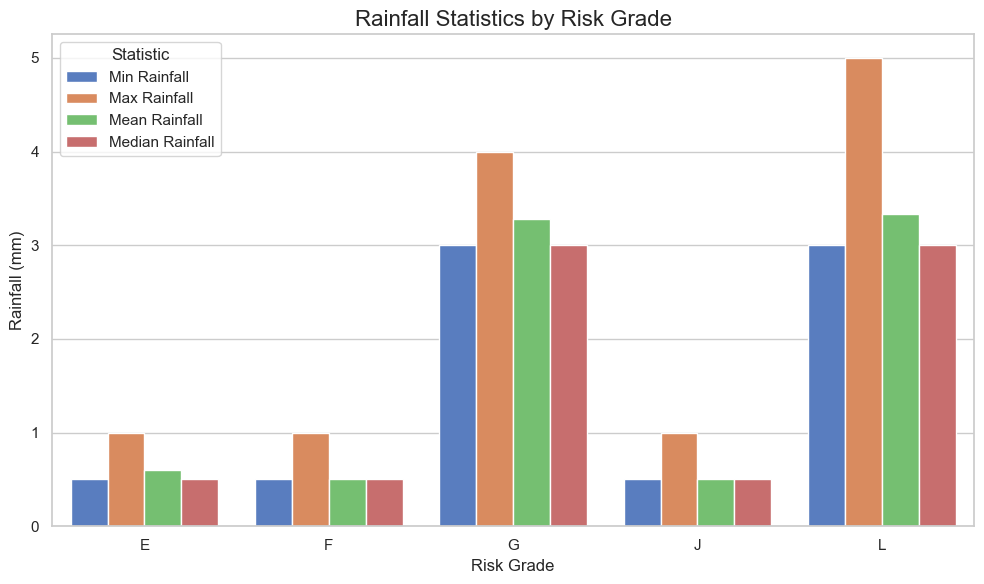

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows에서의 올바른 폰트 경로 사용
font_prop = fm.FontProperties(fname=font_path)

# matplotlib에 폰트 적용
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 올바르게 표시되도록 설정

# 데이터셋 로드
df = pd.read_csv("도로위험상황예보.csv")

# 분석에 필요한 컬럼 선택
columns_of_interest = ["RSK_ELMN_GRD", "RN_1HR", "AIRTP", "LAT", "LOT"]
df = df[columns_of_interest]

# 위험 등급을 숫자 값으로 매핑
grade_mapping = {"E": 1, "F": 2, "G": 3, "J": 4, "L": 5}
inverse_mapping = {1: "E", 2: "F", 3: "G", 4: "J", 5: "L"}
df["RSK_ELMN_GRD"] = df["RSK_ELMN_GRD"].map(grade_mapping)

# RN_1HR을 숫자로 변환, 숫자가 아닌 값은 NaN으로 설정
df["RN_1HR"] = pd.to_numeric(df["RN_1HR"], errors="coerce")

# 'RN_1HR' 또는 'RSK_ELMN_GRD'에 결측치가 있는 행 삭제
df = df.dropna(subset=["RN_1HR", "RSK_ELMN_GRD"])

# 위험 등급별 강수량 통계 계산
rain_stats = df.groupby("RSK_ELMN_GRD")["RN_1HR"].agg(
    min_rain="min",
    max_rain="max",
    mean_rain="mean",
    median_rain="median"
).reset_index()

# 위험 등급을 다시 문자 값으로 매핑
rain_stats["RSK_ELMN_GRD"] = rain_stats["RSK_ELMN_GRD"].map(inverse_mapping)

# 중앙값을 기준으로 한 강수량 경계 계산
rain_boundaries = {}
for i in range(len(rain_stats) - 1):
    grade1, grade2 = rain_stats.iloc[i], rain_stats.iloc[i + 1]
    rain_boundaries[f"{grade1['RSK_ELMN_GRD']}-{grade2['RSK_ELMN_GRD']}"] = (
        grade1["median_rain"] + grade2["median_rain"]
    ) / 2

# 강수량 통계 출력
print("위험 등급별 강수량 통계:")
print(rain_stats)
print("\n중앙값을 기준으로 한 강수량 경계:")
for boundary, rain in rain_boundaries.items():
    print(f"{boundary}: {rain:.2f}mm")

# 위험 등급별 강수량 통계 시각화
sns.set(style="whitegrid")

# 각 위험 등급에 대한 강수량 통계 플롯
fig, ax = plt.subplots(figsize=(10, 6))

# 플롯에서 읽기 쉽게 컬럼 이름 변경
rain_name_mapping = {
    "min_rain": "Min Rainfall",
    "max_rain": "Max Rainfall",
    "mean_rain": "Mean Rainfall",
    "median_rain": "Median Rainfall"
}

rain_stats_long = rain_stats.rename(columns=rain_name_mapping).melt(
    id_vars=["RSK_ELMN_GRD"],
    value_vars=list(rain_name_mapping.values()),
    var_name="Statistic",
    value_name="Rainfall"
)

sns.barplot(
    data=rain_stats_long,
    x="RSK_ELMN_GRD",
    y="Rainfall",
    hue="Statistic",
    palette="muted",
    ax=ax
)

# 제목과 라벨 추가
ax.set_title("Rainfall Statistics by Risk Grade", fontsize=16)
ax.set_xlabel("Risk Grade", fontsize=12)
ax.set_ylabel("Rainfall (mm)", fontsize=12)
ax.legend(title="Statistic")

plt.tight_layout()
plt.show()


## 도로 위험 등급별 온도 통계 분석 및 시각화


위험 등급별 온도 통계:
  RSK_ELMN_GRD  min_temp  max_temp  mean_temp  median_temp
0            E         0         6   2.716981          3.0
1            F         0         6   1.592375          1.0
2            G         0         4   0.905660          0.0
3            J        -6        -1  -1.314103         -1.0
4            L        -4        -1  -1.135900         -1.0

중앙값을 기준으로 한 온도 경계:
E-F: 2.00°C
F-G: 0.50°C
G-J: -0.50°C
J-L: -1.00°C


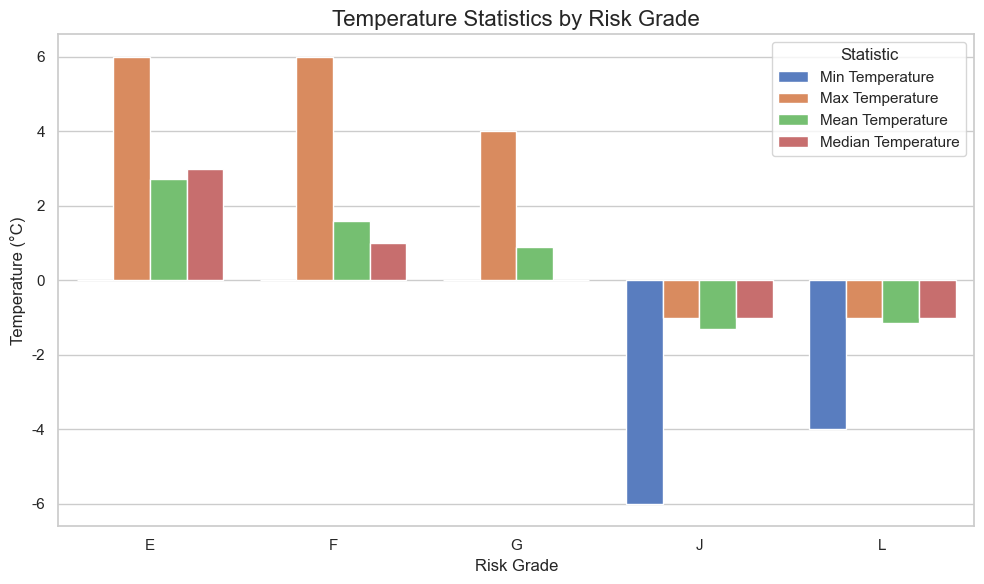

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows에서의 올바른 폰트 경로 사용
font_prop = fm.FontProperties(fname=font_path)

# matplotlib에 폰트 적용
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 올바르게 표시되도록 설정

# 데이터셋 로드
df = pd.read_csv("도로위험상황예보.csv")

# 분석에 필요한 컬럼 선택
columns_of_interest = ["RSK_ELMN_GRD", "RN_1HR", "AIRTP", "LAT", "LOT"]
df = df[columns_of_interest]

# 위험 등급을 숫자 값으로 매핑
grade_mapping = {"E": 1, "F": 2, "G": 3, "J": 4, "L": 5}
inverse_mapping = {1: "E", 2: "F", 3: "G", 4: "J", 5: "L"}
df["RSK_ELMN_GRD"] = df["RSK_ELMN_GRD"].map(grade_mapping)

# AIRTP를 숫자로 변환, 숫자가 아닌 값은 NaN으로 설정
df["AIRTP"] = pd.to_numeric(df["AIRTP"], errors="coerce")

# 'AIRTP' 또는 'RSK_ELMN_GRD'에 결측치가 있는 행 삭제
df = df.dropna(subset=["AIRTP", "RSK_ELMN_GRD"])

# 위험 등급별 온도 통계 계산
grade_stats = df.groupby("RSK_ELMN_GRD")["AIRTP"].agg(
    min_temp="min",
    max_temp="max",
    mean_temp="mean",
    median_temp="median"
).reset_index()

# 위험 등급을 다시 문자 값으로 매핑
grade_stats["RSK_ELMN_GRD"] = grade_stats["RSK_ELMN_GRD"].map(inverse_mapping)

# 중앙값을 기준으로 한 온도 경계 계산
boundaries = {}
for i in range(len(grade_stats) - 1):
    grade1, grade2 = grade_stats.iloc[i], grade_stats.iloc[i + 1]
    boundaries[f"{grade1['RSK_ELMN_GRD']}-{grade2['RSK_ELMN_GRD']}"] = (
        grade1["median_temp"] + grade2["median_temp"]
    ) / 2

# 온도 통계 출력
print("위험 등급별 온도 통계:")
print(grade_stats)
print("\n중앙값을 기준으로 한 온도 경계:")
for boundary, temp in boundaries.items():
    print(f"{boundary}: {temp:.2f}°C")

# 위험 등급별 온도 통계 시각화
sns.set(style="whitegrid")

# 각 위험 등급에 대한 온도 통계 플롯
fig, ax = plt.subplots(figsize=(10, 6))

# 플롯에서 읽기 쉽게 컬럼 이름 변경
stat_name_mapping = {
    "min_temp": "Min Temperature",
    "max_temp": "Max Temperature",
    "mean_temp": "Mean Temperature",
    "median_temp": "Median Temperature"
}

grade_stats_long = grade_stats.rename(columns=stat_name_mapping).melt(
    id_vars=["RSK_ELMN_GRD"],
    value_vars=list(stat_name_mapping.values()),
    var_name="Statistic",
    value_name="Temperature"
)

sns.barplot(
    data=grade_stats_long,
    x="RSK_ELMN_GRD",
    y="Temperature",
    hue="Statistic",
    palette="muted",
    ax=ax
)

# 제목과 라벨 추가
ax.set_title("Temperature Statistics by Risk Grade", fontsize=16)
ax.set_xlabel("Risk Grade", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)
ax.legend(title="Statistic")

plt.tight_layout()
plt.show()


## 겨울철 교통사고 뉴스 크롤링 및 데이터 분석


=== Page 1 ===

1. 제목: 김문수 "배달종사자 사고 위험…플랫폼 운영사 한파대책 필요"
   링크: https://www.newsis.com/view/NISX20241223_0003007422
   미리보기: 이에 김 장관은 이날 한랭질환 예방 3대 수칙(따뜻한 옷, 물, 쉼터)과 겨울철 교통사고 예방 수칙(빙판길 저속 운전, 안전모 착용) 등을 준수할 것을 요청했다. 아울러 김 장관은 "겨울철 도로 위에서 일하는 배달종사자들의 건강과 안전을 세심하게 관리할 필요가 있다"며 "플랫폼 운영사도 적극적으로 한파 대책을...

2. 제목: 노동당국, 겨울철 화재·폭발·붕괴 등 안전사고 예방 점검
   링크: https://biz.heraldcorp.com/article/10022082?ref=naver
   미리보기: 김문수 고용노동부 장관이 23일 서울 영등포구 타임스퀘어 앞 픽업존에서 겨울철 배달종사자 교통사고와 한랭질환 예방을 위한 안전 ON 캠페인을 하고 있다. [고용노동부 제공] 노동당국이 건설업, 제조업, 물류센터와 같은 택배업, 폐기물처리업 등을 대상으로 겨울철 발생할 수 있는 안전사고를 예방하기 위한...

3. 제목: 겨울철 인기 여행지, 카카오내비가 추천해준다
   링크: https://zdnet.co.kr/view/?no=20241223153314
   미리보기: 이를 통해 카카오내비는 겨울철 안전운전과 사고 예방에 기여할 수 있을 것으로 기대하고 있다. 한국도로교통공단에 따르면 최근 5년간 발생한 노면 결빙 사고는 3천900여 건으로, 결빙 교통사고의 치사율은 일반 교통사고보다 1.7배 높다는 분석이 나온 바 있다. 카카오내비는 지난 9일에도 목적지 설정 없이...

4. 제목: 장수군 '도로정비평가' 1위··· 안전 교통환경 조성
   링크: http://www.jjn.co.kr/news/articleView.html?idxno=992807
   미리보기: 장수군은 겨울철 설해 대책에서 빠른 제설작업 추진으로 교통사고 발생 건

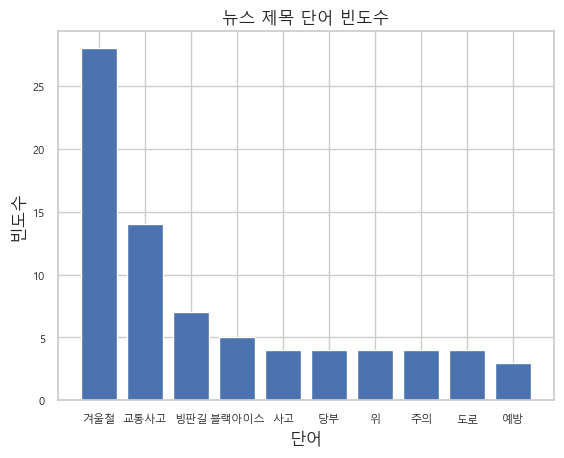

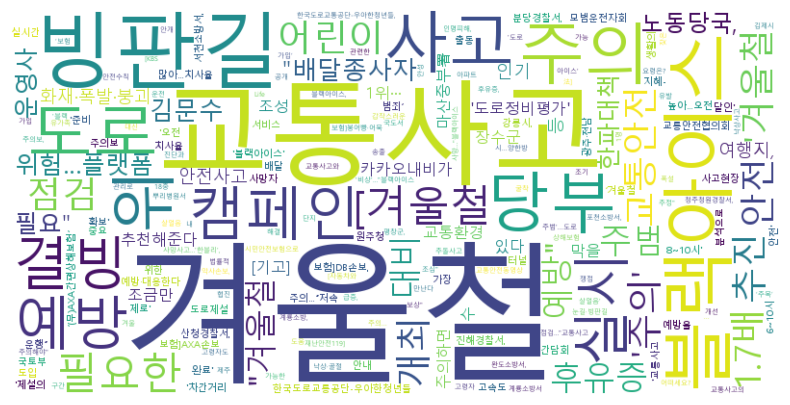

In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우에서 사용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 제대로 표시되게 설정

# 검색어 및 URL 설정
search_query = "겨울철 교통사고"
base_url = "https://search.naver.com/search.naver?where=news&query={query}&start={start}"

# 헤더 설정
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"
}

# 뉴스 기사 가져오기 함수 정의
def fetch_news(query, pages):
    news_data = []  # 데이터를 저장할 리스트

    for page in range(1, pages + 1):
        start = (page - 1) * 10 + 1
        url = base_url.format(query=query, start=start)

        # 요청 및 응답 받기
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')

            # 뉴스 기사 정보 가져오기
            news_items = soup.select(".news_area")
            
            print(f"\n=== Page {page} ===\n")
            for idx, item in enumerate(news_items, 1):
                # 제목과 링크 추출
                title = item.select_one(".news_tit").get_text()
                link = item.select_one(".news_tit")['href']
                
                # 미리보기 텍스트 추출
                preview = item.select_one(".dsc_txt_wrap").get_text() if item.select_one(".dsc_txt_wrap") else "No preview available."

                print(f"{idx}. 제목: {title}")
                print(f"   링크: {link}")
                print(f"   미리보기: {preview}\n")

                # 데이터를 리스트에 추가
                news_data.append({"제목": title, "링크": link, "미리보기": preview})
        else:
            print(f"Failed to fetch data for page {page}. Status code: {response.status_code}")

    return news_data

# 단어 빈도수 및 워드클라우드 시각화 함수 정의
def visualize_word_frequency_and_cloud(titles):
    # 모든 제목에서 단어 추출
    words = " ".join(titles).split()
    
    # 단어 빈도 계산
    word_counts = Counter(words)

    # 가장 많이 등장한 단어 10개 선택
    most_common_words = word_counts.most_common(10)

    # 텍스트로 출력
    print("\n단어 빈도수 분석 결과:")
    for word, count in most_common_words:
        print(f"{word}: {count}")

    # 그래프 시각화
    words, counts = zip(*most_common_words)
    plt.bar(words, counts)
    plt.xlabel('단어')
    plt.ylabel('빈도수')
    plt.title('뉴스 제목 단어 빈도수')
    plt.xticks(fontsize=8)  # x축 폰트 크기
    plt.yticks(fontsize=8)  # y축 폰트 크기
    plt.show()

    # 워드클라우드 생성 및 시각화
    wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('')
    plt.show()

# 실행
def main():
    pages = 5
    news_data = fetch_news(search_query, pages)

    # 데이터를 DataFrame으로 변환
    df = pd.DataFrame(news_data)

    # 엑셀 파일로 저장
    excel_filename = "news_results.xlsx"
    df.to_excel(excel_filename, index=False)
    print(f"\nData saved to {excel_filename}")

    # 제목 단어 빈도수 분석 및 시각화
    titles = df["제목"].tolist()
    visualize_word_frequency_and_cloud(titles)

# 실행
main()

## 기온과 강수량에 따른 도로 위험 요소 등급 경향 분석

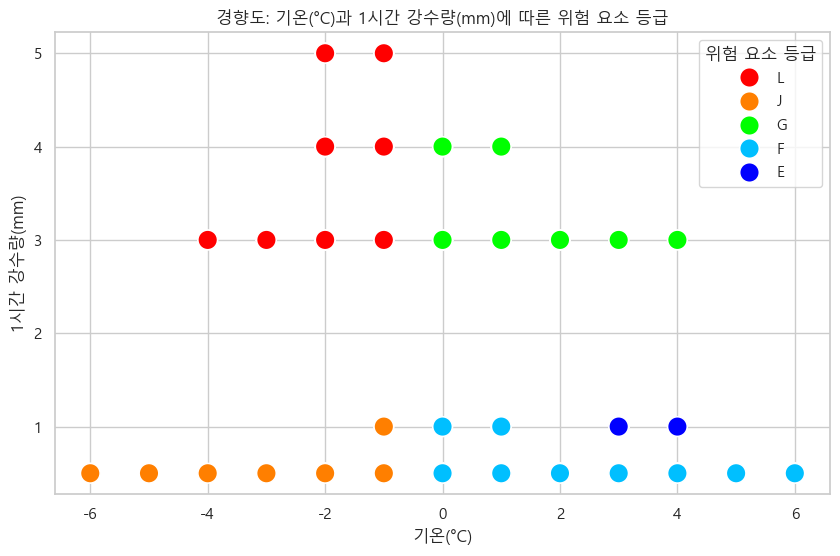

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우에서 사용 (리눅스에서는 'NanumGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 제대로 표시되게 설정

# 데이터 로드
df = pd.read_csv("도로위험상황예보.csv")
df['RN_1HR'] = pd.to_numeric(df['RN_1HR'], errors='coerce')  # 문자열 → 숫자형 변환

# 필요한 열만 선택
df = df[['RSK_ELMN_GRD', 'AIRTP', 'RN_1HR']]  

# 첫 번째 인덱스를 제외하고 데이터 저장
df = df.iloc[1:]

# 결측값 제거
df = df.dropna(subset=['RSK_ELMN_GRD', 'AIRTP', 'RN_1HR'])  # 결측값 제거

# AIRTP 열을 숫자형으로 변환 (문자열로 되어 있을 경우 숫자로 변환)
df['AIRTP'] = pd.to_numeric(df['AIRTP'], errors='coerce')

# 기온(AIRTP)의 절댓값을 기준으로 오름차순 정렬
df = df.loc[df['AIRTP'].apply(abs).sort_values().index]


# 위험 요소 등급에 따른 색상 매핑
custom_palette = {
    'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
    'J': '#FF7F00',    # 두번째 위험도 -> 주황
    'G': '#00FF00',    # 낮은 위험도 -> 초록
    'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
    'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
}

# Seaborn scatterplot으로 경향도 분석
plt.figure(figsize=(10, 6))

# 기온(AIRTP)와 1시간 강수량(RN_1HR)을 'RSK_ELMN_GRD'에 대해 hue로 표시
sns.scatterplot(
    x='AIRTP', 
    y='RN_1HR', 
    hue='RSK_ELMN_GRD', 
    data=df,
    palette=custom_palette,  # 사용자 정의 색상 사용
    hue_order=["L", "J", "G", "F", "E"],  # 범례 순서 지정
    s=200  # 점 크기 지정 (기본값보다 커지게 설정)
)

# 그래프 제목과 레이블 설정
plt.title("경향도: 기온(°C)과 1시간 강수량(mm)에 따른 위험 요소 등급")
plt.xlabel("기온(°C)")
plt.ylabel("1시간 강수량(mm)")

# 범례 설정
plt.legend(title="위험 요소 등급", loc='upper right')

# 그래프 보여주기
plt.show()

## 기온과 강수량에 따른 위험 요소 등급의 반전 경향 분석

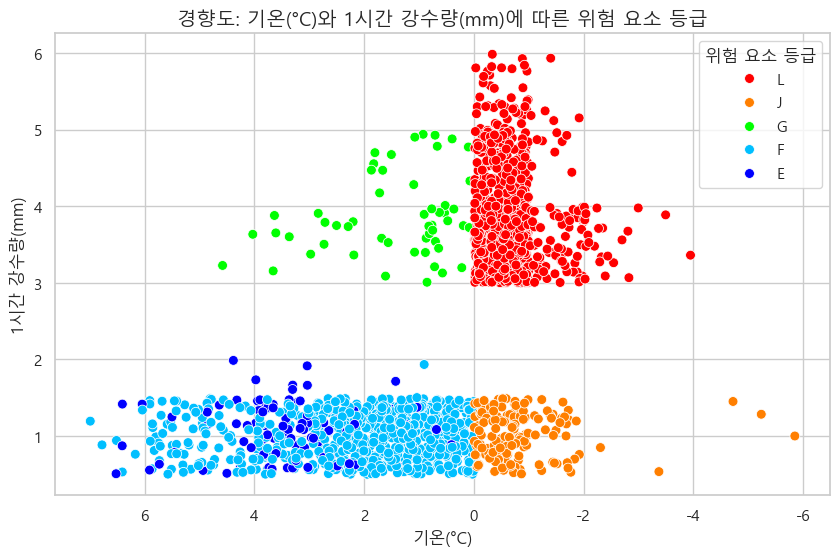

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우에서 사용 (리눅스에서는 'NanumGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 제대로 표시되게 설정

# 데이터 로드
df = pd.read_csv("도로위험상황예보.csv")
df['RN_1HR'] = pd.to_numeric(df['RN_1HR'], errors='coerce')  # 문자열 → 숫자형 변환

# 필요한 열만 선택
df = df[['RSK_ELMN_GRD', 'AIRTP', 'RN_1HR']]  

# 첫 번째 인덱스를 제외하고 데이터 저장
df = df.iloc[1:]

# 결측값 제거
df = df.dropna(subset=['RSK_ELMN_GRD', 'AIRTP', 'RN_1HR'])  # 결측값 제거

# AIRTP 열을 숫자형으로 변환 (문자열로 되어 있을 경우 숫자로 변환)
df['AIRTP'] = pd.to_numeric(df['AIRTP'], errors='coerce')

# 기온(AIRTP)의 절댓값을 기준으로 오름차순 정렬
df = df.loc[df['AIRTP'].apply(abs).sort_values().index]

# 위험 요소 등급에 따른 색상 매핑
custom_palette = {
    'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
    'J': '#FF7F00',    # 두번째 위험도 -> 주황
    'G': '#00FF00',    # 낮은 위험도 -> 초록
    'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
    'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
}

# 0~0.99 범위의 랜덤 값 생성하여 새로운 열 추가
df['RN_1HR_random'] = df['RN_1HR'] + np.random.rand(len(df)) * 0.99
df['AIRTP_random'] = df['AIRTP'] + np.random.rand(len(df)) * 0.99

# Seaborn scatterplot으로 경향도 분석
plt.figure(figsize=(10, 6))

# 기온(AIRTP_random)와 1시간 강수량(RN_1HR_random)을 'RSK_ELMN_GRD'에 대해 hue로 표시
sns.scatterplot(
    x='AIRTP_random', 
    y='RN_1HR_random', 
    hue='RSK_ELMN_GRD', 
    data=df,
    palette=custom_palette,  # 사용자 정의 색상 사용
    hue_order=["L", "J", "G", "F", "E"],  # 범례 순서 지정
    s=50  # 점 크기 지정 (기본값보다 커지게 설정)
)

# x축을 반대로 뒤집기
plt.gca().invert_xaxis()

# 그래프 제목과 레이블 설정
plt.title("경향도: 기온(°C)와 1시간 강수량(mm)에 따른 위험 요소 등급", fontsize=14)
plt.xlabel("기온(°C)", fontsize=12)
plt.ylabel("1시간 강수량(mm)", fontsize=12)

# 범례 설정
plt.legend(title="위험 요소 등급", loc='upper right')

# 그래프 보여주기
plt.show()


## 위험 요소 등급과 강수량 간의 관계 및 회귀 분석

회귀선의 기울기: 0.831


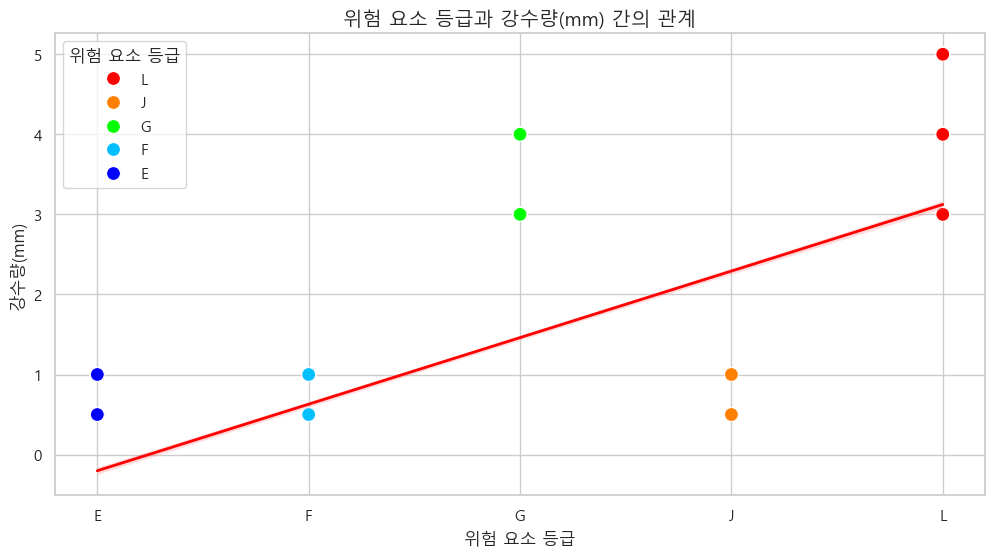

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 제대로 표시

# 데이터 로드
df = pd.read_csv("도로위험상황예보.csv")  # 실행 환경에 CSV 파일 필요
df['RN_1HR'] = pd.to_numeric(df['RN_1HR'], errors='coerce')  # 강수량 열 숫자형으로 변환
df['AIRTP'] = pd.to_numeric(df['AIRTP'], errors='coerce')  # 기온 열 숫자형으로 변환

# 필요한 열만 선택
df = df[['RSK_ELMN_GRD', 'AIRTP', 'RN_1HR']]

# 결측값 제거
df = df.dropna()

# 위험 등급을 숫자로 변환하여 시각화
risk_grade_mapping = {'E': 1, 'F': 2, 'G': 3, 'J': 4, 'L': 5}
df['Risk_Grade_Num'] = df['RSK_ELMN_GRD'].map(risk_grade_mapping)

# 사용자 정의 색상 팔레트
custom_palette = {
    'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
    'J': '#FF7F00',    # 두번째 위험도 -> 주황
    'G': '#00FF00',    # 낮은 위험도 -> 초록
    'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
    'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
}

# Seaborn scatterplot으로 경향도 분석
plt.figure(figsize=(12, 6))

# 위험 등급(Risk_Grade_Num)과 강수량(RN_1HR)을 시각화
sns.scatterplot(
    x="Risk_Grade_Num",  # x축을 위험 등급으로 변경
    y="RN_1HR", 
    hue="RSK_ELMN_GRD", 
    data=df, 
    palette=custom_palette,  # 사용자 정의 색상 사용
    hue_order=["L", "J", "G", "F", "E"],  # 범례 순서 지정
    s=100  # 점 크기 설정
)

# 위험 등급(Risk_Grade_Num)과 강수량(RN_1HR) 간의 회귀선 추가
sns.regplot(
    x="Risk_Grade_Num",  # x축을 위험 등급으로 변경
    y="RN_1HR", 
    data=df, 
    scatter=False,  # 회귀선만 그리기 위해 scatter=False 설정
    color='blue',  # 회귀선 색상
    line_kws={'color': 'red', 'linewidth': 2}  # 회귀선의 색상과 두께 설정
)

# 회귀선 기울기 구하기
slope, intercept, r_value, p_value, std_err = linregress(df['Risk_Grade_Num'], df['RN_1HR'])

# 기울기 출력
print(f"회귀선의 기울기: {slope:.3f}")

# 그래프 제목과 축 레이블 추가
plt.title("위험 요소 등급과 강수량(mm) 간의 관계", fontsize=14)
plt.xlabel("위험 요소 등급", fontsize=12)
plt.ylabel("강수량(mm)", fontsize=12)
plt.xticks(ticks=list(risk_grade_mapping.values()), labels=list(risk_grade_mapping.keys()))  # x축 레이블을 위험 등급으로

# 범례 설정
plt.legend(title="위험 요소 등급")

# 그래프 보여주기
plt.show()


## 위험 요소 등급과 기온 간의 관계 분석 및 회귀 시각화


회귀선의 기울기: -0.943


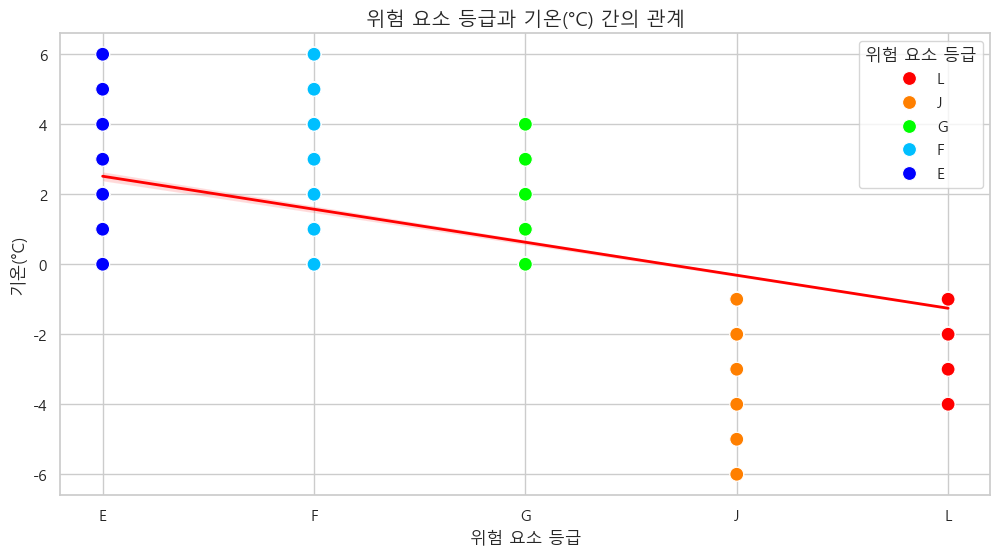

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 제대로 표시

# 데이터 로드
df = pd.read_csv("도로위험상황예보.csv")  # 실행 환경에 CSV 파일 필요
df['RN_1HR'] = pd.to_numeric(df['RN_1HR'], errors='coerce')  # 강수량 열 숫자형으로 변환
df['AIRTP'] = pd.to_numeric(df['AIRTP'], errors='coerce')  # 기온 열 숫자형으로 변환

# 필요한 열만 선택
df = df[['RSK_ELMN_GRD', 'AIRTP', 'RN_1HR']]

# 결측값 제거
df = df.dropna()

# 위험 등급을 숫자로 변환하여 시각화
risk_grade_mapping = {'E': 1, 'F': 2, 'G': 3, 'J': 4, 'L': 5}
df['Risk_Grade_Num'] = df['RSK_ELMN_GRD'].map(risk_grade_mapping)

# 사용자 정의 색상 팔레트
custom_palette = {
    'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
    'J': '#FF7F00',    # 두번째 위험도 -> 주황
    'G': '#00FF00',    # 낮은 위험도 -> 초록
    'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
    'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
}

# Seaborn scatterplot으로 경향도 분석
plt.figure(figsize=(12, 6))

# 위험 등급(Risk_Grade_Num)과 기온(AIRTP)을 시각화
sns.scatterplot(
    x="Risk_Grade_Num",  # x축을 위험 등급으로 변경
    y="AIRTP",  # y축을 기온으로 설정
    hue="RSK_ELMN_GRD", 
    data=df, 
    palette=custom_palette,  # 사용자 정의 색상 사용
    hue_order=["L", "J", "G", "F", "E"],  # 범례 순서 지정
    s=100  # 점 크기 설정
)

# 위험 등급(Risk_Grade_Num)과 기온(AIRTP) 간의 회귀선 추가
sns.regplot(
    x="Risk_Grade_Num",  # x축을 위험 등급으로 설정
    y="AIRTP",  # y축을 기온으로 설정
    data=df, 
    scatter=False,  # 회귀선만 그리기 위해 scatter=False 설정
    color='blue',  # 회귀선 색상
    line_kws={'color': 'red', 'linewidth': 2}  # 회귀선의 색상과 두께 설정
)

# 회귀선 기울기 구하기
slope, intercept, r_value, p_value, std_err = linregress(df['Risk_Grade_Num'], df['AIRTP'])

# 기울기 출력
print(f"회귀선의 기울기: {slope:.3f}")

# 그래프 제목과 축 레이블 추가
plt.title("위험 요소 등급과 기온(°C) 간의 관계", fontsize=14)
plt.xlabel("위험 요소 등급", fontsize=12)
plt.ylabel("기온(°C)", fontsize=12)
plt.xticks(ticks=list(risk_grade_mapping.values()), labels=list(risk_grade_mapping.keys()))  # x축 레이블을 위험 등급으로

# 범례 설정
plt.legend(title="위험 요소 등급")

# 그래프 보여주기
plt.show()

## 1시간 강수량에 따른 위험 등급 분포 시각화

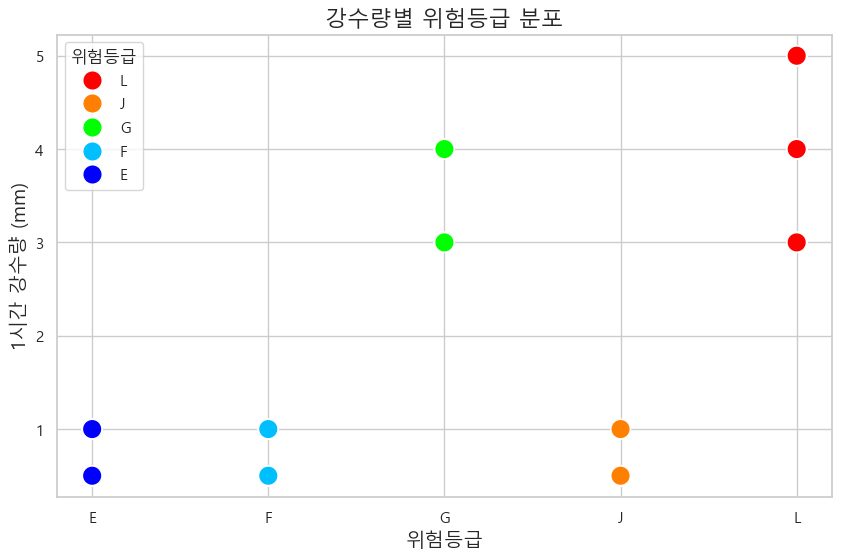

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드 및 결측값 제거
df_clean = df.dropna(subset=['RN_1HR', 'RSK_ELMN_GRD'])
df['RN_1HR'] = pd.to_numeric(df['RN_1HR'], errors='coerce')  # 문자열 → 숫자형 변환

# RSK_ELMN_GRD 순서 지정 (E, F, G, J, L 순으로)
df_clean['RSK_ELMN_GRD'] = pd.Categorical(df_clean['RSK_ELMN_GRD'], categories=["E", "F", "G", "J", "L"], ordered=True)

# 색상 맵핑: RSK_ELMN_GRD별 색상 설정
color_mapping = {
    'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
    'J': '#FF7F00',    # 두번째 위험도 -> 주황
    'G': '#00FF00',    # 낮은 위험도 -> 초록
    'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
    'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
}

# 산점도 그리기 (점 크기 200으로 설정)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='RSK_ELMN_GRD', y='RN_1HR', hue='RSK_ELMN_GRD', data=df_clean,
                palette=color_mapping, s=200, marker='o')

# 그래프 제목과 레이블 설정
plt.title("강수량별 위험등급 분포", fontsize=16)
plt.ylabel("1시간 강수량 (mm)", fontsize=14)
plt.xlabel("위험등급", fontsize=14)

# 범례 순서 설정: E, F, G, J, L 순으로 설정
handles, labels = plt.gca().get_legend_handles_labels()
order = ["L", "J", "G", "F", "E"]
handle_dict = dict(zip(labels, handles))  # 라벨과 핸들을 매핑
ordered_handles = [handle_dict[label] for label in order]  # 순서대로 핸들 정렬
ordered_labels = order  # 라벨 순서

# 범례 추가
plt.legend(handles=ordered_handles, labels=ordered_labels, title='위험등급')

# 그래프 보여주기
plt.show()

## 기온 구간별 위험 요소 등급 분포 분석


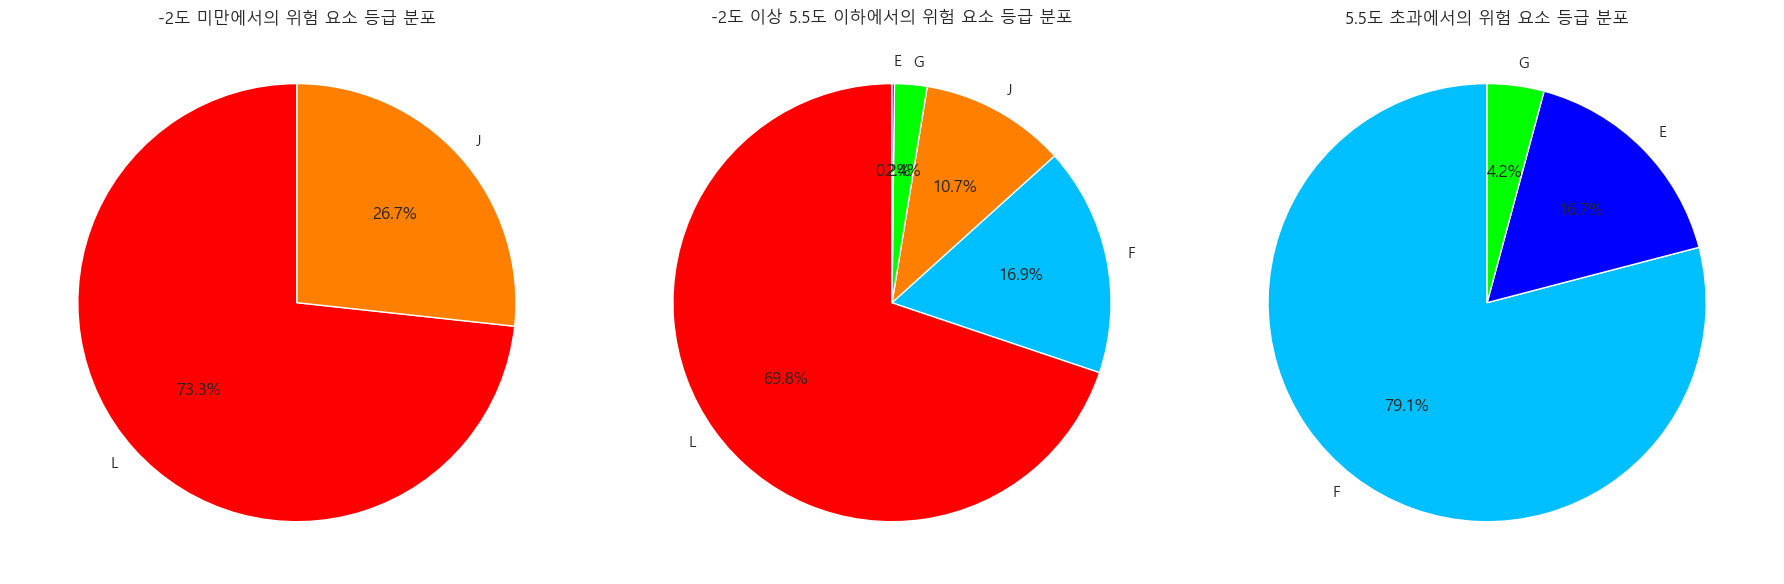

In [39]:
# 데이터 로드
df = pd.read_csv("도로위험상황예보.csv")

# 필요한 열만 선택
df = df[['RSK_ELMN_GRD', 'AIRTP']]  

# 첫 번째 인덱스를 제외하고 데이터 저장
df = df.iloc[1:]

# 결측값 제거
df = df.dropna(subset=['RSK_ELMN_GRD', 'AIRTP'])  # 결측값 제거

# AIRTP 열을 숫자형으로 변환
df['AIRTP'] = pd.to_numeric(df['AIRTP'], errors='coerce')

# # -5도 이하
# df_below_mfive = df[df['AIRTP'] < -2]

# # -5도 이상 0도 이하
# df_below_zero = df[(df['AIRTP'] <= 5.5) & (df['AIRTP'] >= -2)]

# # 0도 초과 10도 이하
# df_below_five = df[(df['AIRTP'] > 5.5)]

# -5도 이하
df_below_mfive = df[df['AIRTP'] < -1]

# -5도 이상 0도 이하
df_below_zero = df[(df['AIRTP'] <= 0) & (df['AIRTP'] >= -1)]

# 0도 초과 10도 이하
df_below_five = df[(df['AIRTP'] > 0)]


# 위험 요소 등급별 빈도 세기
grade_counts_00 = df_below_zero['RSK_ELMN_GRD'].value_counts()
grade_counts_01 = df_below_mfive['RSK_ELMN_GRD'].value_counts()
grade_counts_02 = df_below_five['RSK_ELMN_GRD'].value_counts()

# 컬러 매핑
color_mapping = {
    'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
    'J': '#FF7F00',    # 두번째 위험도 -> 주황
    'G': '#00FF00',    # 낮은 위험도 -> 초록
    'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
    'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
}

# 파이 차트를 하나의 화면에 3개 그리기 위한 함수
def plot_pie_chart_subplot(grade_counts, title, ax):
    colors = [color_mapping.get(grade, "gray") for grade in grade_counts.index]
    
    ax.pie(grade_counts, labels=grade_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(title)
    ax.axis('equal')  # 원형으로 표시되도록 설정

# Subplot을 사용하여 3개의 파이 차트를 나란히 그리기
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 한 줄에 3개 차트 배치

plot_pie_chart_subplot(grade_counts_01, "-2도 미만에서의 위험 요소 등급 분포", axes[0])
plot_pie_chart_subplot(grade_counts_00, "-2도 이상 5.5도 이하에서의 위험 요소 등급 분포", axes[1])
plot_pie_chart_subplot(grade_counts_02, "5.5도 초과에서의 위험 요소 등급 분포", axes[2])

# 그래프 표시
plt.tight_layout()
plt.show()

# import pandas as pd
# import matplotlib.pyplot as plt

# # 데이터 로드
# df = pd.read_csv("도로위험상황예보.csv")

# # 필요한 열만 선택
# df = df[['RSK_ELMN_GRD', 'AIRTP']]  

# # 첫 번째 인덱스를 제외하고 데이터 저장
# df = df.iloc[1:]

# # 결측값 제거
# df = df.dropna(subset=['RSK_ELMN_GRD', 'AIRTP'])  # 결측값 제거

# # AIRTP 열을 숫자형으로 변환
# df['AIRTP'] = pd.to_numeric(df['AIRTP'], errors='coerce')

# # -5도 이하
# df_below_mfive = df[df['AIRTP'] < -1]

# # -5도 이상 0도 이하
# df_below_zero = df[(df['AIRTP'] <= 0) & (df['AIRTP'] >= -1)]

# # 0도 초과 10도 이하
# df_below_five = df[(df['AIRTP'] > 0)]

# # 위험 요소 등급별 빈도 세기
# grade_counts_00 = df_below_zero['RSK_ELMN_GRD'].value_counts()
# grade_counts_01 = df_below_mfive['RSK_ELMN_GRD'].value_counts()
# grade_counts_02 = df_below_five['RSK_ELMN_GRD'].value_counts()

# # 컬러 매핑
# color_mapping = {
#     'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
#     'J': '#FF7F00',    # 두번째 위험도 -> 주황
#     'G': '#00FF00',    # 낮은 위험도 -> 초록
#     'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
#     'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
# }

# # 바 차트를 하나의 화면에 3개 그리기 위한 함수
# def plot_bar_chart(grade_counts, title, ax):
#     colors = [color_mapping.get(grade, "gray") for grade in grade_counts.index]
    
#     ax.bar(grade_counts.index, grade_counts.values, color=colors)
#     ax.set_title(title)
#     ax.set_xlabel('위험 요소 등급')
#     ax.set_ylabel('빈도')
#     ax.set_xticks(grade_counts.index)  # x축 눈금 설정
#     ax.set_ylim(0, grade_counts.max() + 1)  # y축 범위 설정

# # Subplot을 사용하여 3개의 바 차트를 나란히 그리기
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 한 줄에 3개 차트 배치

# plot_bar_chart(grade_counts_01, "-2도 미만에서의 위험 요소 등급 분포", axes[0])
# plot_bar_chart(grade_counts_00, "-2도 이상 0도 이하에서의 위험 요소 등급 분포", axes[1])
# plot_bar_chart(grade_counts_02, "0도 초과에서의 위험 요소 등급 분포", axes[2])

# # 그래프 표시
# plt.tight_layout()
# plt.show()


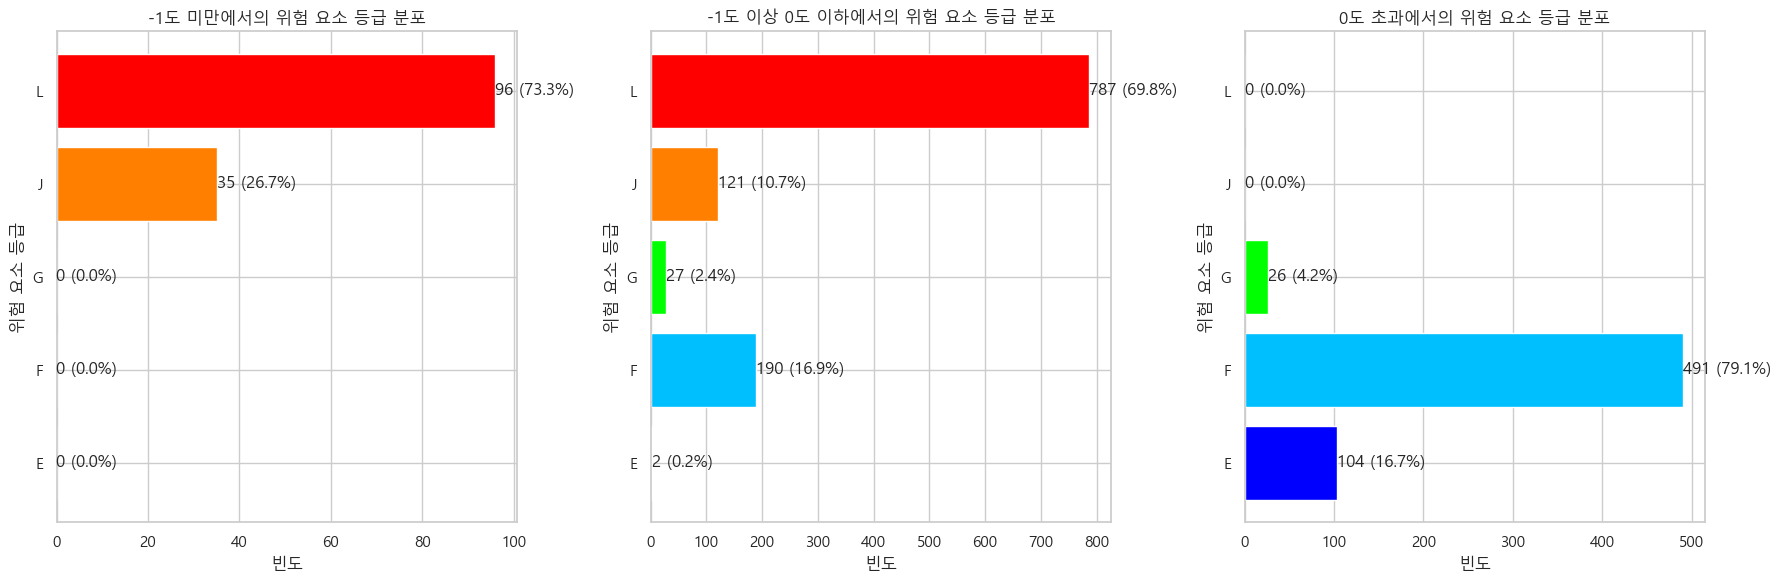

In [69]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # 데이터 로드
# df = pd.read_csv("도로위험상황예보.csv")

# # 필요한 열만 선택
# df = df[['RSK_ELMN_GRD', 'AIRTP']]  

# # 첫 번째 인덱스를 제외하고 데이터 저장
# df = df.iloc[1:]

# # 결측값 제거
# df = df.dropna(subset=['RSK_ELMN_GRD', 'AIRTP'])  # 결측값 제거

# # AIRTP 열을 숫자형으로 변환
# df['AIRTP'] = pd.to_numeric(df['AIRTP'], errors='coerce')

# # -5도 이하
# df_below_mfive = df[df['AIRTP'] < -1]

# # -5도 이상 0도 이하
# df_below_zero = df[(df['AIRTP'] <= 0) & (df['AIRTP'] >= -1)]

# # 0도 초과 10도 이하
# df_below_five = df[(df['AIRTP'] > 0)]

# # 위험 요소 등급별 빈도 세기
# grade_counts_00 = df_below_zero['RSK_ELMN_GRD'].value_counts()
# grade_counts_01 = df_below_mfive['RSK_ELMN_GRD'].value_counts()
# grade_counts_02 = df_below_five['RSK_ELMN_GRD'].value_counts()

# # 컬러 매핑
# color_mapping = {
#     'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
#     'J': '#FF7F00',    # 두번째 위험도 -> 주황
#     'G': '#00FF00',    # 낮은 위험도 -> 초록
#     'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
#     'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
# }

# # 바 차트를 하나의 화면에 3개 그리기 위한 함수
# def plot_bar_chart(grade_counts, title, ax):
#     colors = [color_mapping.get(grade, "gray") for grade in grade_counts.index]
    
#     ax.bar(grade_counts.index, grade_counts.values, color=colors)
#     ax.set_title(title)
#     ax.set_xlabel('위험 요소 등급')
#     ax.set_ylabel('빈도')
#     ax.set_xticks(grade_counts.index)  # x축 눈금 설정
#     ax.set_ylim(0, grade_counts.max() + 1)  # y축 범위 설정

# # Subplot을 사용하여 3개의 바 차트를 나란히 그리기
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 한 줄에 3개 차트 배치

# plot_bar_chart(grade_counts_01, "-1도 미만에서의 위험 요소 등급 분포", axes[0])
# plot_bar_chart(grade_counts_00, "-1도 이상 0도 이하에서의 위험 요소 등급 분포", axes[1])
# plot_bar_chart(grade_counts_02, "0도 초과에서의 위험 요소 등급 분포", axes[2])

# # 그래프 표시
# plt.tight_layout()
# plt.show()

# # import pandas as pd
# # import matplotlib.pyplot as plt

# # # 데이터 로드
# # df = pd.read_csv("도로위험상황예보.csv")

# # # 필요한 열만 선택
# # df = df[['RSK_ELMN_GRD', 'AIRTP']]  

# # # 첫 번째 인덱스를 제외하고 데이터 저장
# # df = df.iloc[1:]

# # # 결측값 제거
# # df = df.dropna(subset=['RSK_ELMN_GRD', 'AIRTP'])  # 결측값 제거

# # # AIRTP 열을 숫자형으로 변환
# # df['AIRTP'] = pd.to_numeric(df['AIRTP'], errors='coerce')

# # # -5도 이하
# # df_below_mfive = df[df['AIRTP'] < -1]

# # # -5도 이상 0도 이하
# # df_below_zero = df[(df['AIRTP'] <= 0) & (df['AIRTP'] >= -1)]

# # # 0도 초과 10도 이하
# # df_below_five = df[(df['AIRTP'] > 0)]

# # # 위험 요소 등급별 빈도 세기
# # grade_counts_00 = df_below_zero['RSK_ELMN_GRD'].value_counts()
# # grade_counts_01 = df_below_mfive['RSK_ELMN_GRD'].value_counts()
# # grade_counts_02 = df_below_five['RSK_ELMN_GRD'].value_counts()

# # # 컬러 매핑
# # color_mapping = {
# #     'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
# #     'J': '#FF7F00',    # 두번째 위험도 -> 주황
# #     'G': '#00FF00',    # 낮은 위험도 -> 초록
# #     'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
# #     'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
# # }

# # # 바 차트를 하나의 화면에 3개 그리기 위한 함수
# # def plot_bar_chart(grade_counts, title, ax, ylim=None):
# #     colors = [color_mapping.get(grade, "gray") for grade in grade_counts.index]
    
# #     ax.bar(grade_counts.index, grade_counts.values, color=colors)
# #     ax.set_title(title)
# #     ax.set_xlabel('위험 요소 등급')
# #     ax.set_ylabel('빈도')
# #     ax.set_xticks(grade_counts.index)  # x축 눈금 설정
# #     if ylim is not None:
# #         ax.set_ylim(0, ylim)  # y축 범위 설정

# # # Subplot을 사용하여 3개의 바 차트를 나란히 그리기
# # fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 한 줄에 3개 차트 배치

# # plot_bar_chart(grade_counts_01, "-2도 미만에서의 위험 요소 등급 분포", axes[0], ylim=100)
# # plot_bar_chart(grade_counts_00, "-2도 이상 0도 이하에서의 위험 요소 등급 분포", axes[1])
# # plot_bar_chart(grade_counts_02, "0도 초과에서의 위험 요소 등급 분포", axes[2])

# # # 그래프 표시
# # plt.tight_layout()
# # plt.show()


# # import pandas as pd
# # import matplotlib.pyplot as plt

# # # 데이터 로드
# # df = pd.read_csv("도로위험상황예보.csv")

# # # 필요한 열만 선택
# # df = df[['RSK_ELMN_GRD', 'AIRTP']]  

# # # 첫 번째 인덱스를 제외하고 데이터 저장
# # df = df.iloc[1:]

# # # 결측값 제거
# # df = df.dropna(subset=['RSK_ELMN_GRD', 'AIRTP'])  # 결측값 제거

# # # AIRTP 열을 숫자형으로 변환
# # df['AIRTP'] = pd.to_numeric(df['AIRTP'], errors='coerce')

# # # -5도 이하
# # df_below_mfive = df[df['AIRTP'] < -1]

# # # -5도 이상 0도 이하
# # df_below_zero = df[(df['AIRTP'] <= 0) & (df['AIRTP'] >= -1)]

# # # 0도 초과 10도 이하
# # df_below_five = df[(df['AIRTP'] > 0)]

# # # 위험 요소 등급별 빈도 세기
# # grade_counts_00 = df_below_zero['RSK_ELMN_GRD'].value_counts()
# # grade_counts_01 = df_below_mfive['RSK_ELMN_GRD'].value_counts()
# # grade_counts_02 = df_below_five['RSK_ELMN_GRD'].value_counts()

# # # 컬러 매핑
# # color_mapping = {
# #     'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
# #     'J': '#FF7F00',    # 두번째 위험도 -> 주황
# #     'G': '#00FF00',    # 낮은 위험도 -> 초록
# #     'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
# #     'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
# # }

# # # 바 차트를 하나의 화면에 3개 그리기 위한 함수
# # def plot_bar_chart(grade_counts, title, ax, ylim=None):
# #     colors = [color_mapping.get(grade, "gray") for grade in grade_counts.index]
    
# #     bars = ax.bar(grade_counts.index, grade_counts.values, color=colors)
# #     ax.set_title(title)
# #     ax.set_xlabel('위험 요소 등급')
# #     ax.set_ylabel('빈도')
# #     ax.set_xticks(grade_counts.index)  # x축 눈금 설정
# #     if ylim is not None:
# #         ax.set_ylim(0, ylim)  # y축 범위 설정

# #     # 각 막대 위에 값 표시
# #     for bar in bars:
# #         yval = bar.get_height()
# #         ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# # # Subplot을 사용하여 3개의 바 차트를 나란히 그리기
# # fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 한 줄에 3개 차트 배치

# # plot_bar_chart(grade_counts_01, "-2도 미만에서의 위험 요소 등급 분포", axes[0])
# # plot_bar_chart(grade_counts_00, "-2도 이상 0도 이하에서의 위험 요소 등급 분포", axes[1])
# # plot_bar_chart(grade_counts_02, "0도 초과에서의 위험 요소 등급 분포", axes[2])

# # # 그래프 표시
# # plt.tight_layout()
# # plt.show()



# # import pandas as pd
# # import matplotlib.pyplot as plt

# # # 데이터 로드
# # df = pd.read_csv("도로위험상황예보.csv")

# # # 필요한 열만 선택
# # df = df[['RSK_ELMN_GRD', 'AIRTP']]  

# # # 첫 번째 인덱스를 제외하고 데이터 저장
# # df = df.iloc[1:]

# # # 결측값 제거
# # df = df.dropna(subset=['RSK_ELMN_GRD', 'AIRTP'])  # 결측값 제거

# # # AIRTP 열을 숫자형으로 변환
# # df['AIRTP'] = pd.to_numeric(df['AIRTP'], errors='coerce')

# # # -5도 이하
# # df_below_mfive = df[df['AIRTP'] < -1]

# # # -5도 이상 0도 이하
# # df_below_zero = df[(df['AIRTP'] <= 0) & (df['AIRTP'] >= -1)]

# # # 0도 초과 10도 이하
# # df_below_five = df[(df['AIRTP'] > 0)]

# # # 위험 요소 등급별 빈도 세기
# # grade_counts_00 = df_below_zero['RSK_ELMN_GRD'].value_counts()
# # grade_counts_01 = df_below_mfive['RSK_ELMN_GRD'].value_counts()
# # grade_counts_02 = df_below_five['RSK_ELMN_GRD'].value_counts()

# # # 원하는 순서로 정렬
# # desired_order = ['E', 'F', 'G', 'J', 'L']
# # grade_counts_00 = grade_counts_00.reindex(desired_order, fill_value=0)
# # grade_counts_01 = grade_counts_01.reindex(desired_order, fill_value=0)
# # grade_counts_02 = grade_counts_02.reindex(desired_order, fill_value=0)

# # # 컬러 매핑
# # color_mapping = {
# #     'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
# #     'J': '#FF7F00',    # 두번째 위험도 -> 주황
# #     'G': '#00FF00',    # 낮은 위험도 -> 초록
# #     'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
# #     'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
# # }

# # # 바 차트를 하나의 화면에 3개 그리기 위한 함수
# # def plot_bar_chart(grade_counts, title, ax, ylim=None):
# #     colors = [color_mapping.get(grade, "gray") for grade in grade_counts.index]
    
# #     bars = ax.bar(grade_counts.index, grade_counts.values, color=colors)
# #     ax.set_title(title)
# #     ax.set_xlabel('위험 요소 등급')
# #     ax.set_ylabel('빈도')
# #     ax.set_xticks(grade_counts.index)  # x축 눈금 설정
# #     if ylim is not None:
# #         ax.set_ylim(0, ylim)  # y축 범위 설정

# #     # 각 막대 위에 값 표시
# #     for bar in bars:
# #         yval = bar.get_height()
# #         ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# # # Subplot을 사용하여 3개의 바 차트를 나란히 그리기
# # fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 한 줄에 3개 차트 배치

# # plot_bar_chart(grade_counts_01, "-2도 미만에서의 위험 요소 등급 분포", axes[0])
# # plot_bar_chart(grade_counts_00, "-2도 이상 0도 이하에서의 위험 요소 등급 분포", axes[1])
# # plot_bar_chart(grade_counts_02, "0도 초과에서의 위험 요소 등급 분포", axes[2])

# # # 그래프 표시
# # plt.tight_layout()
# # plt.show()




# import pandas as pd
# import matplotlib.pyplot as plt

# # 데이터 로드
# df = pd.read_csv("도로위험상황예보.csv")

# # 필요한 열만 선택
# df = df[['RSK_ELMN_GRD', 'AIRTP']]  

# # 첫 번째 인덱스를 제외하고 데이터 저장
# df = df.iloc[1:]

# # 결측값 제거
# df = df.dropna(subset=['RSK_ELMN_GRD', 'AIRTP'])  # 결측값 제거

# # AIRTP 열을 숫자형으로 변환
# df['AIRTP'] = pd.to_numeric(df['AIRTP'], errors='coerce')

# # -5도 이하
# df_below_mfive = df[df['AIRTP'] < -1]

# # -5도 이상 0도 이하
# df_below_zero = df[(df['AIRTP'] <= 0) & (df['AIRTP'] >= -1)]

# # 0도 초과 10도 이하
# df_below_five = df[(df['AIRTP'] > 0)]

# # 위험 요소 등급별 빈도 세기
# grade_counts_00 = df_below_zero['RSK_ELMN_GRD'].value_counts()
# grade_counts_01 = df_below_mfive['RSK_ELMN_GRD'].value_counts()
# grade_counts_02 = df_below_five['RSK_ELMN_GRD'].value_counts()

# # 원하는 순서로 정렬
# desired_order = ['E', 'F', 'G', 'J', 'L']
# grade_counts_00 = grade_counts_00.reindex(desired_order, fill_value=0)
# grade_counts_01 = grade_counts_01.reindex(desired_order, fill_value=0)
# grade_counts_02 = grade_counts_02.reindex(desired_order, fill_value=0)

# # 컬러 매핑
# color_mapping = {
#     'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
#     'J': '#FF7F00',    # 두번째 위험도 -> 주황
#     'G': '#00FF00',    # 낮은 위험도 -> 초록
#     'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
#     'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
# }

# # 가로 바 차트를 하나의 화면에 3개 그리기 위한 함수
# def plot_horizontal_bar_chart(grade_counts, title, ax, xlim=None):
#     colors = [color_mapping.get(grade, "gray") for grade in grade_counts.index]
    
#     # 가로 바 차트 그리기
#     bars = ax.barh(grade_counts.index, grade_counts.values, color=colors)
#     ax.set_title(title)
#     ax.set_xlabel('빈도')
#     ax.set_ylabel('위험 요소 등급')
#     if xlim is not None:
#         ax.set_xlim(0, xlim)  # x축 범위 설정

#     # 각 막대 옆에 값 표시
#     for bar in bars:
#         ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, int(bar.get_width()), 
#                 ha='left', va='center')

# # Subplot을 사용하여 3개의 가로 바 차트를 나란히 그리기
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 한 줄에 3개 차트 배치

# plot_horizontal_bar_chart(grade_counts_01, "-2도 미만에서의 위험 요소 등급 분포", axes[0])
# plot_horizontal_bar_chart(grade_counts_00, "-2도 이상 0도 이하에서의 위험 요소 등급 분포", axes[1])
# plot_horizontal_bar_chart(grade_counts_02, "0도 초과에서의 위험 요소 등급 분포", axes[2])

# # 그래프 표시
# plt.tight_layout()
# plt.show()



import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv("도로위험상황예보.csv")

# 필요한 열만 선택
df = df[['RSK_ELMN_GRD', 'AIRTP']]  

# 첫 번째 인덱스를 제외하고 데이터 저장
df = df.iloc[1:]

# 결측값 제거
df = df.dropna(subset=['RSK_ELMN_GRD', 'AIRTP'])  # 결측값 제거

# AIRTP 열을 숫자형으로 변환
df['AIRTP'] = pd.to_numeric(df['AIRTP'], errors='coerce')

# -5도 이하
df_below_mfive = df[df['AIRTP'] < -1]

# -5도 이상 0도 이하
df_below_zero = df[(df['AIRTP'] <= 0) & (df['AIRTP'] >= -1)]

# 0도 초과 10도 이하
df_below_five = df[(df['AIRTP'] > 0)]

# 위험 요소 등급별 빈도 세기
grade_counts_00 = df_below_zero['RSK_ELMN_GRD'].value_counts()
grade_counts_01 = df_below_mfive['RSK_ELMN_GRD'].value_counts()
grade_counts_02 = df_below_five['RSK_ELMN_GRD'].value_counts()

# 원하는 순서로 정렬
desired_order = ['E', 'F', 'G', 'J', 'L']
grade_counts_00 = grade_counts_00.reindex(desired_order, fill_value=0)
grade_counts_01 = grade_counts_01.reindex(desired_order, fill_value=0)
grade_counts_02 = grade_counts_02.reindex(desired_order, fill_value=0)

# 컬러 매핑
color_mapping = {
    'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
    'J': '#FF7F00',    # 두번째 위험도 -> 주황
    'G': '#00FF00',    # 낮은 위험도 -> 초록
    'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
    'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
}

# 가로 바 차트를 하나의 화면에 3개 그리기 위한 함수
def plot_horizontal_bar_chart(grade_counts, title, ax):
    colors = [color_mapping.get(grade, "gray") for grade in grade_counts.index]
    
    # 가로 바 차트 그리기
    bars = ax.barh(grade_counts.index, grade_counts.values, color=colors)
    ax.set_title(title)
    ax.set_xlabel('빈도')
    ax.set_ylabel('위험 요소 등급')

    # 각 막대 옆에 값과 퍼센트 표시
    total = grade_counts.sum()
    for bar in bars:
        width = bar.get_width()
        percent = (width / total) * 100 if total > 0 else 0
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{int(width)} ({percent:.1f}%)', 
                ha='left', va='center')

# Subplot을 사용하여 3개의 가로 바 차트를 나란히 그리기
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 한 줄에 3개 차트 배치

plot_horizontal_bar_chart(grade_counts_01, "-1도 미만에서의 위험 요소 등급 분포", axes[0])
plot_horizontal_bar_chart(grade_counts_00, "-1도 이상 0도 이하에서의 위험 요소 등급 분포", axes[1])
plot_horizontal_bar_chart(grade_counts_02, "0도 초과에서의 위험 요소 등급 분포", axes[2])

# 그래프 표시
plt.tight_layout()
plt.show()







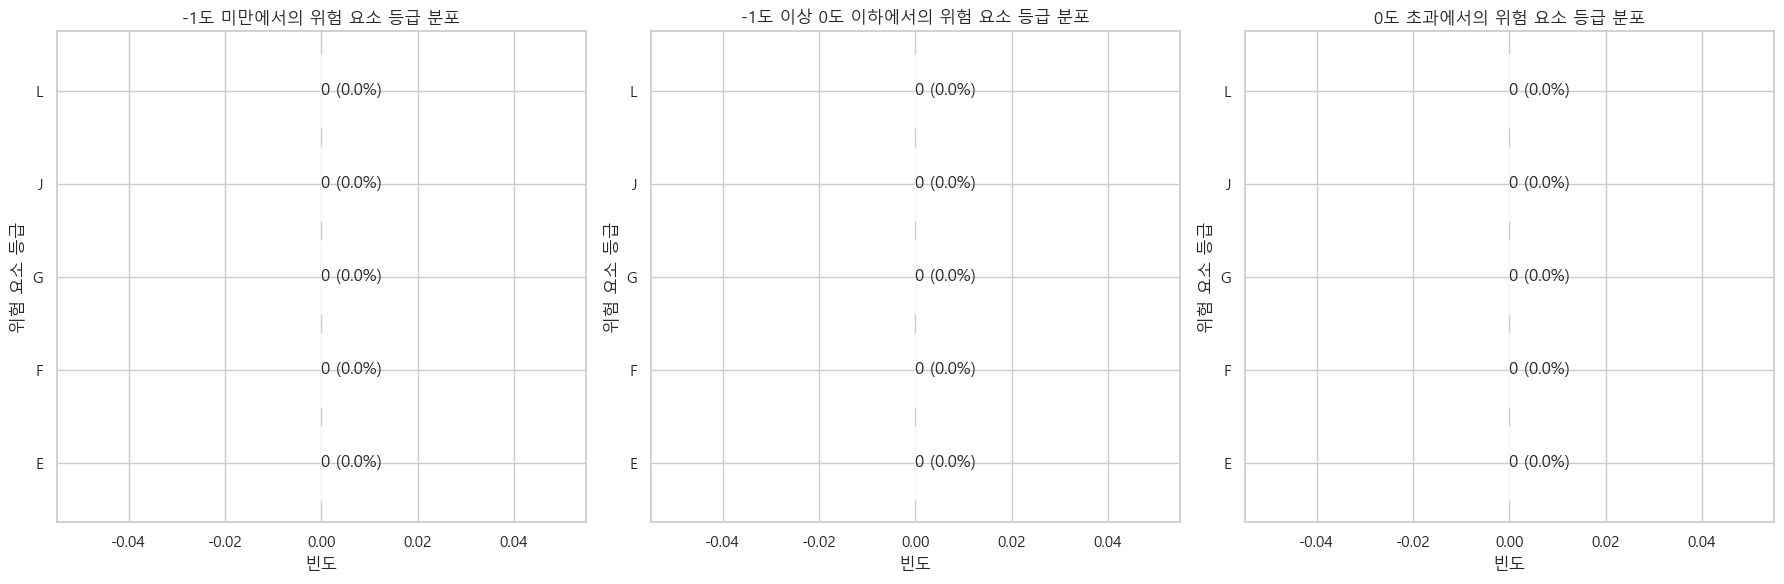

In [71]:
### 강수량 기준
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv("도로위험상황예보.csv")

# 필요한 열만 선택
df = df[['RSK_ELMN_GRD', 'AIRTP']]  

# 첫 번째 인덱스를 제외하고 데이터 저장
df = df.iloc[1:]

# 결측값 제거
df = df.dropna(subset=['RSK_ELMN_GRD', 'AIRTP'])  # 결측값 제거

# AIRTP 열을 숫자형으로 변환
df['RSK_ELMN_GRD'] = pd.to_numeric(df['RSK_ELMN_GRD'], errors='coerce')

# -5도 이하
df_below_mfive = df[df['RSK_ELMN_GRD'] < -1]

# -5도 이상 0도 이하
df_below_zero = df[(df['RSK_ELMN_GRD'] <= 0) & (df['RSK_ELMN_GRD'] >= -1)]

# 0도 초과 10도 이하
df_below_five = df[(df['RSK_ELMN_GRD'] > 0)]

# 위험 요소 등급별 빈도 세기
grade_counts_00 = df_below_zero['RSK_ELMN_GRD'].value_counts()
grade_counts_01 = df_below_mfive['RSK_ELMN_GRD'].value_counts()
grade_counts_02 = df_below_five['RSK_ELMN_GRD'].value_counts()

# 원하는 순서로 정렬
desired_order = ['E', 'F', 'G', 'J', 'L']
grade_counts_00 = grade_counts_00.reindex(desired_order, fill_value=0)
grade_counts_01 = grade_counts_01.reindex(desired_order, fill_value=0)
grade_counts_02 = grade_counts_02.reindex(desired_order, fill_value=0)

# 컬러 매핑
color_mapping = {
    'L': '#FF0000',    # 가장 높은 위험도 -> 빨강
    'J': '#FF7F00',    # 두번째 위험도 -> 주황
    'G': '#00FF00',    # 낮은 위험도 -> 초록
    'F': '#00BFFF',    # 아주 낮은 위험도 -> 하늘색
    'E': '#0000FF'     # 가장 낮은 위험도 -> 파랑
}

# 가로 바 차트를 하나의 화면에 3개 그리기 위한 함수
def plot_horizontal_bar_chart(grade_counts, title, ax):
    colors = [color_mapping.get(grade, "gray") for grade in grade_counts.index]
    
    # 가로 바 차트 그리기
    bars = ax.barh(grade_counts.index, grade_counts.values, color=colors)
    ax.set_title(title)
    ax.set_xlabel('빈도')
    ax.set_ylabel('위험 요소 등급')

    # 각 막대 옆에 값과 퍼센트 표시
    total = grade_counts.sum()
    for bar in bars:
        width = bar.get_width()
        percent = (width / total) * 100 if total > 0 else 0
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{int(width)} ({percent:.1f}%)', 
                ha='left', va='center')

# Subplot을 사용하여 3개의 가로 바 차트를 나란히 그리기
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 한 줄에 3개 차트 배치

# df['RSK_ELMN_GRD']로 나타내기
plot_horizontal_bar_chart(grade_counts_01, "-1도 미만에서의 위험 요소 등급 분포", axes[0])
plot_horizontal_bar_chart(grade_counts_00, "-1도 이상 0도 이하에서의 위험 요소 등급 분포", axes[1])
plot_horizontal_bar_chart(grade_counts_02, "0도 초과에서의 위험 요소 등급 분포", axes[2])

# 그래프 표시
plt.tight_layout()
plt.show()


## 중기 기상 데이터 크롤링 및 좌표 추가 분석


In [14]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
from datetime import datetime, timedelta
from geopy.geocoders import Nominatim

n_values = [1, 7, 9, 10, 13, 16, 22, 28, 34, 40]  # 지정된 특정 행 번호

def get_weather_info_mid_term():
    # Selenium WebDriver 설정
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)

    # URL 접속
    url = "https://www.weather.go.kr/w/weather/forecast/mid-term.do"
    driver.get(url)
    time.sleep(5)  # 페이지 로드 대기

    weather_data = []  # 데이터 저장 리스트

    # 오늘 날짜 계산
    today = datetime.today()
    day_index = [(today + timedelta(days=i)).strftime("%d일") for i in range(4, 8)]

    # 모든 행 처리 (n_values 포함)
    rows = driver.find_elements(By.CSS_SELECTOR, "div.tab-menu-cont > div:nth-child(9) > table > tbody > tr")
    row_count = len(rows)

    for n in range(1, row_count + 1):
        try:
            # 지역명 추출
            region_selector = f"div.tab-menu-cont > div:nth-child(9) > table > tbody > tr:nth-child({n}) > td.midterm-city > span"
            region = driver.find_element(By.CSS_SELECTOR, region_selector).text.strip()

            # day_column 동적 설정
            if n in n_values:
                day_columns = [3, 4, 5, 6]  # n_values에 포함된 경우
            else:
                day_columns = [2, 3, 4, 5]  # 그 외의 경우

            # 날짜별 데이터 추출
            temp_data = {"지역": region}
            for day, day_column in zip(day_index, day_columns):
                # 최고 기온 추출
                high_temp_selector = f"div.tab-menu-cont > div:nth-child(9) > table > tbody > tr:nth-child({n}) > td:nth-child({day_column}) > span.tmx"
                high_temp = driver.find_element(By.CSS_SELECTOR, high_temp_selector).text.strip()

                # 최저 기온 추출
                low_temp_selector = f"div.tab-menu-cont > div:nth-child(9) > table > tbody > tr:nth-child({n}) > td:nth-child({day_column}) > span.tmn"
                low_temp = driver.find_element(By.CSS_SELECTOR, low_temp_selector).text.strip()

                # 최고/최저 기온 결합하여 저장
                temp_data[day] = f"{low_temp}/{high_temp}"

            weather_data.append(temp_data)
        except Exception as e:
            print(f"Error processing row {n}: {e}")
            continue  # 에러 발생 시 건너뜀

    driver.quit()  # 브라우저 종료
    return weather_data

def add_coordinates(data):
    # Geolocator 설정
    geolocator = Nominatim(user_agent="weather_locator")
    for entry in data:
        try:
            if entry["지역"] == "고창":
                entry["위도"] = 35.4358216
                entry["경도"] = 126.7020806
            elif entry["지역"] == "통영":
                entry["위도"] = 34.8544227
                entry["경도"] = 128.433182
            else:
                location = geolocator.geocode(entry["지역"])
                if location:
                    entry["위도"] = location.latitude
                    entry["경도"] = location.longitude
                else:
                    entry["위도"] = None
                    entry["경도"] = None
        except Exception as e:
            print(f"Error fetching coordinates for {entry['지역']}: {e}")
            entry["위도"] = None
            entry["경도"] = None
    return data

def save_to_excel(data, file_name="mid_term_weather_data_with_coordinates.xlsx"):
    # 데이터프레임 생성
    df = pd.DataFrame(data)
    # 엑셀 파일로 저장
    df.to_excel(file_name, index=False)
    print(f"데이터가 {file_name}에 저장되었습니다.")

# 실행 및 출력
weather_data = get_weather_info_mid_term()
weather_data_with_coordinates = add_coordinates(weather_data)
print(weather_data_with_coordinates)
save_to_excel(weather_data_with_coordinates)

[{'지역': '서울', '30일': '-2/3', '31일': '-4/4', '01일': '-6/1', '02일': '-6/2', '위도': 37.5666791, '경도': 126.9782914}, {'지역': '인천', '30일': '-2/2', '31일': '-3/4', '01일': '-4/2', '02일': '-4/2', '위도': 37.456, '경도': 126.7052}, {'지역': '수원', '30일': '-3/3', '31일': '-4/4', '01일': '-6/2', '02일': '-6/2', '위도': 37.2658097, '경도': 126.9999102}, {'지역': '파주', '30일': '-6/3', '31일': '-8/3', '01일': '-10/1', '02일': '-11/1', '위도': 37.8150577, '경도': 126.7924283}, {'지역': '이천', '30일': '-4/4', '31일': '-6/4', '01일': '-7/2', '02일': '-8/2', '위도': 37.2642411, '경도': 127.4422242}, {'지역': '평택', '30일': '-3/3', '31일': '-4/5', '01일': '-6/1', '02일': '-6/2', '위도': 36.9908233, '경도': 127.0853183}, {'지역': '춘천', '30일': '-5/4', '31일': '-8/3', '01일': '-10/1', '02일': '-10/1', '위도': 37.8845604, '경도': 127.716664}, {'지역': '원주', '30일': '-3/3', '31일': '-5/4', '01일': '-7/1', '02일': '-8/1', '위도': 37.3164083, '경도': 127.9228206}, {'지역': '강릉', '30일': '1/7', '31일': '-2/6', '01일': '-2/4', '02일': '-4/5', '위도': 37.76452, '경도': 128.8993979}, {'지역': 

## 단기 기상 예보 데이터 크롤링 및 엑셀 저장 자동화


In [15]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
from selenium.webdriver.common.action_chains import ActionChains

def get_weather_info_dynamic():
    # Selenium WebDriver 설정
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    driver.maximize_window()  # 창 최대화

    # URL 접속
    url = "https://www.weather.go.kr/w/weather/forecast/short-term.do"
    driver.get(url)

    time.sleep(5)  # 페이지 로드 대기

    weather_data = []
    # 검색어 입력
    global search_query 
    search_query = input("검색어를 입력하세요: ")
    input_selector = "input.input"
    input_element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, input_selector))
    )
    input_element.click()  # 입력 필드 클릭
    input_element.send_keys(search_query)  # 검색어 입력
    input_element.send_keys(Keys.ENTER)  # 엔터 입력

    time.sleep(2)  # 엔터 후 대기

    # 탭 키 3번 동작 (ActionChains 활용)
    actions = ActionChains(driver)
    for _ in range(3):
        actions.send_keys(Keys.TAB)
        time.sleep(1)
    actions.send_keys(Keys.ENTER)
    actions.perform()  # 동작 실행

    time.sleep(5)  # 최종 결과 대기

    for i in range(11):  # 1번째와 2번째 슬라이드 선택
        # 동적으로 날짜 선택
        date_selector = f"#digital-forecast div.dfs-daily-slide-wrap > div:nth-child({i + 1}) h4 > span:nth-child(1)"
        date_element = driver.find_element(By.CSS_SELECTOR, date_selector)
        date_text = date_element.text.strip() if date_element else "날짜 정보 없음"

        # 동적으로 최저 기온 선택
        min_temp_selector = f"#digital-forecast div.dfs-daily-slide-wrap > div:nth-child({i + 1}) div.daily-minmax > div:nth-child(1) > span"
        min_temp_element = driver.find_element(By.CSS_SELECTOR, min_temp_selector)
        min_temp_text = min_temp_element.text.strip() if min_temp_element else "최저 기온 정보 없음"

        # 동적으로 최고 기온 선택
        max_temp_selector = f"#digital-forecast div.dfs-daily-slide-wrap > div:nth-child({i + 1}) div.daily-minmax > div:nth-child(2) > span"
        max_temp_element = driver.find_element(By.CSS_SELECTOR, max_temp_selector)
        max_temp_text = max_temp_element.text.strip() if max_temp_element else "최고 기온 정보 없음"

        # 데이터 저장
        weather_data.append({
            "날짜": date_text,
            "최저 기온": min_temp_text,
            "최고 기온": max_temp_text
        })

    # WebDriver 종료
    #driver.quit()

    return weather_data

def save_to_excel(data, file_name="weather_data.xlsx"):
    # 데이터프레임 생성
    df = pd.DataFrame(data)
    # 엑셀 파일로 저장
    df.to_excel(file_name, index=False)
    print(f"데이터가 {file_name}에 저장되었습니다.")

# 실행 및 출력
data = get_weather_info_dynamic()
for weather in data:
    print(f"날짜: {weather['날짜']}, 최저 기온: {weather['최저 기온']}, 최고 기온: {weather['최고 기온']}")

save_to_excel(data)

날짜: 26일, 최저 기온: 0℃, 최고 기온: 1℃
날짜: 27일, 최저 기온: -6℃, 최고 기온: 0℃
날짜: 28일, 최저 기온: -6℃, 최고 기온: 1℃
날짜: 29일, 최저 기온: -2℃, 최고 기온: 5℃
날짜: 30일, 최저 기온: 4℃, 최고 기온: 7℃
날짜: 31일, 최저 기온: -2℃, 최고 기온: 2℃
날짜: 1일, 최저 기온: -3℃, 최고 기온: 4℃
날짜: 2일, 최저 기온: -4℃, 최고 기온: 2℃
날짜: 3일, 최저 기온: -4℃, 최고 기온: 2℃
날짜: 4일, 최저 기온: -4℃, 최고 기온: 3℃
날짜: 5일, 최저 기온: -3℃, 최고 기온: 3℃
데이터가 weather_data.xlsx에 저장되었습니다.


## 기온에 따른 빙결 위험 등급 분석 및 시각화


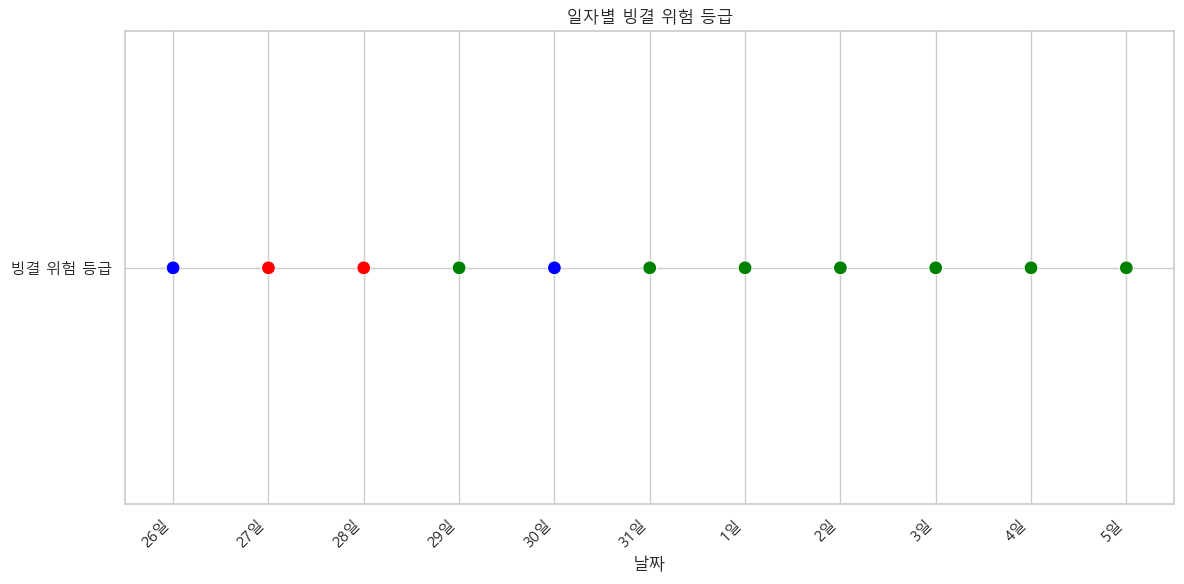

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 엑셀에서 데이터 불러오기
def load_weather_data(file_name="weather_data.xlsx"):
    df = pd.read_excel(file_name)
    return df
# 기온에 따른 빙결 위험 등급을 반환하는 함수
def categorize_freezing_risk(temp):
    try:
        # 기온에서 숫자만 추출 (℃ 기호 등 제거)
        temp = float(str(temp).replace('℃', '').replace('°', '').strip())
        if temp < -5:
            return 'J', 'red'  # J (빨강): -5도 미만
        elif -5 <= temp < 0:
            return 'F', 'green'  # F (초록): 0도 ~ -5도
        elif temp >= 0:
            return 'B', 'blue'  # B (파랑): 0도 이상
    except (ValueError, TypeError):
        return '정보 없음', 'gray'  # 기온 정보가 없거나 변환 실패할 경우

#기온에 따른 빙결 위험 등급을 시각화하는 함수
def visualize_weather(df):
    dates = []
    freezing_risks = []
    colors = []

    for index, row in df.iterrows():
        date = row["날짜"]
        min_temp = row["최저 기온"]
        # 최저 기온을 기준으로 위험 등급을 매기기
        grade, color = categorize_freezing_risk(min_temp)
        dates.append(date)
        freezing_risks.append(grade)
        colors.append(color)

    # 시각화
    df["빙결 위험 등급"] = freezing_risks
    df["색상"] = colors

    # 시각화
    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 제대로 표시
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x="날짜", y=["빙결 위험 등급"]*len(df), data=df, hue="빙결 위험 등급", palette={"J": "red", "F": "green", "B": "blue", "정보 없음": "gray"}, s=100, legend=None)
    plt.xticks(rotation=45, ha='right')
    plt.title("일자별 빙결 위험 등급")
    plt.xlabel("날짜")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

# 실행 및 출력
df = load_weather_data()  # 엑셀에서 데이터 불러오기
visualize_weather(df)  # 시각화

## 도로 블랙아이스 중기 예보: 기온에 따른 빙결 위험군 분석 및 시각화


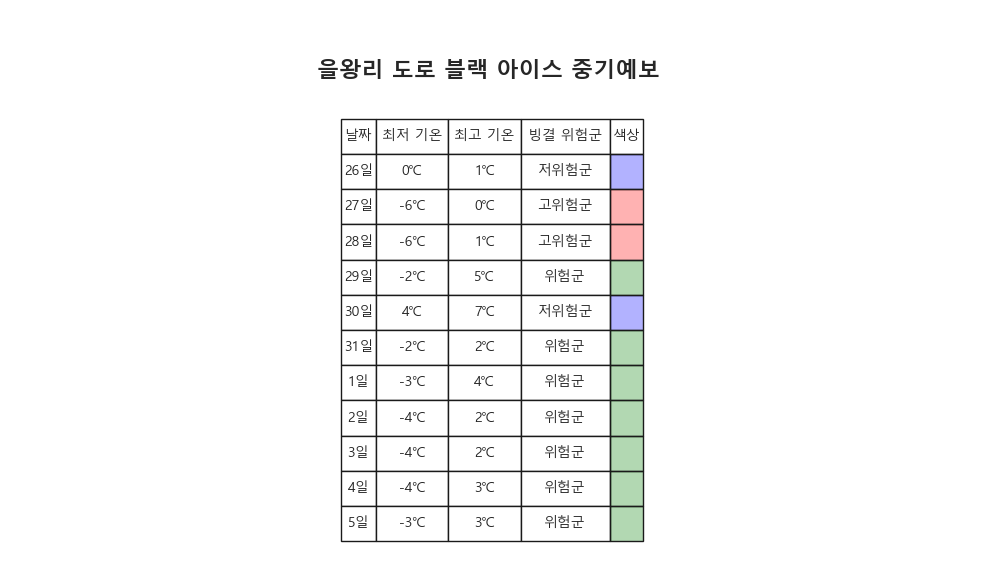

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 제대로 표시

# 엑셀에서 데이터 불러오기
def load_weather_data(file_name="weather_data.xlsx"):
    df = pd.read_excel(file_name)
    return df

def categorize_freezing_risk(temp):
    """기온에 따른 빙결 위험 등급을 반환하는 함수"""
    try:
        # 기온에서 숫자만 추출 (℃ 기호 등 제거)
        temp = float(str(temp).replace('℃', '').replace('°', '').strip())
        if temp < -5:
            return '고위험군', mcolors.to_rgba('red', alpha=1)  # 연한 빨강
        elif -5 <= temp < 0:
            return '위험군', mcolors.to_rgba('green', alpha=1)  # 연한 초록
        elif temp >= 0:
            return '저위험군', mcolors.to_rgba('blue', alpha=1)  # 연한 파랑
    except (ValueError, TypeError):
        return '정보 없음', mcolors.to_rgba('gray', alpha=1)  # 연한 회색

def visualize_weather_table(df, search_query):
    """기온에 따른 빙결 위험 등급을 표로 시각화하는 함수"""
    # 날짜, 최저 기온, 빙결 위험 등급 열 생성
    dates = []
    min_temps = []
    freezing_risks = []
    colors = []  # 색상 리스트

    for index, row in df.iterrows():
        date = row["날짜"]
        min_temp = row["최저 기온"]
        
        # "정보 없음"이 아니면 기온을 기준으로 빙결 위험 등급을 매김
        grade, color = categorize_freezing_risk(min_temp)
        dates.append(date)
        min_temps.append(min_temp)
        freezing_risks.append(grade)
        colors.append(color)

    # 데이터프레임에 결과 저장
    df["최저 기온"] = min_temps
    df["빙결 위험군"] = freezing_risks
    df["색상"] = colors  # 색상 열 추가

    # 표 출력
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 각 행에 대해 색상을 지정
    cell_colors = []
    for i, color in enumerate(colors):
        row_color = ['white', 'white', 'white', color]  # 색상은 마지막 열에만 적용
        cell_colors.append(row_color)

    # 표 그리기
    ax.axis('off')  # 표 주위에 축을 제거
    table = ax.table(cellText=df.values,
                    colLabels=df.columns,
                    loc="center", cellLoc="center")
    
    # 행 간 간격 조정
    table.scale(1, 2.0)  # 행 높이를 두 배로 설정

    # 셀 색상 설정
    for (row, col), cell in table.get_celld().items():
        if row > 0 and col == 4:  # 데이터 행의 "색상" 열에만 색상 적용
            grade_color = {'고위험군': mcolors.to_rgba('red', alpha=0.3),
                           '위험군': mcolors.to_rgba('green', alpha=0.3),
                           '저위험군': mcolors.to_rgba('blue', alpha=0.3)}.get(df.iloc[row - 1]['빙결 위험군'], mcolors.to_rgba('gray', alpha=0.3))
            cell.set_facecolor(grade_color)
            cell.set_text_props(text="")  # 텍스트 제거

    # 폰트 크기 설정
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))

    # 그래프 제목 설정
    title = f"\n\n{search_query} 도로 블랙 아이스 중기예보 "
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 실행 및 출력
# search_query = "서울 지역"  # 검색어 예시
df = load_weather_data()  # 엑셀에서 데이터 불러오기
visualize_weather_table(df, search_query)  # 시각화
